# Fingerprint-based similarity scores

## Challenge
1. Many different fingerprints AND possible variations thereof (e.g. count/binary, log, weighted...) AND different metrics lead to **a lot** of possible variations!
2. No ground truth, so it is hard to measure what is good and what is better...

Data:

Compare multiple fingerprints on the "ms2 structures" dataset [Bushuiev 2024].

In [1]:
import os
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

#from matchms.importing import load_from_mgf

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [2]:
filename = "compounds_unique_inchikey14.pickle"
compounds = pd.read_pickle(os.path.join(path_data, filename))
compounds.head()

,inchikey,inchi,smiles,spectrum_id
0,AAAQFGUYHFJNHI,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(ccc(OC)c2...,None
1,AABFWJDLCCDJJN,InChI=1S/C22H16N2O/c1-25-15-9-10-20-19(13-15)1...,COc1cc2c(cc1)[nH]c1c2ccnc1-c1cccc2ccccc12,None
2,AABILZKQMVKFHP,InChI=1S/C21H33NO8/c1-7-13(2)18(23)30-16-9-11-...,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,MSBNK-NaToxAq-NA003250
3,AABUHSBGEIUSRJ,InChI=1S/C17H16N2O2/c1-13(20)18-15-8-10-16(11-...,CC(O)=Nc1ccc(NC(=O)C=Cc2ccccc2)cc1,CCMSLIB00010107357
4,AABUKWVVUWBZCS,InChI=1S/C21H14O3/c22-16-11-12-17-18(13-16)24-...,O=c1oc2cc(O)ccc2c(-c2ccccc2)c1-c1ccccc1,CCMSLIB00010104862


In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

def calculate_mass(smiles):
    # Convert SMILES string to a molecule object
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return "Invalid SMILES"
    # Calculate the molecular mass
    mass = Descriptors.MolWt(molecule)
    return mass

In [4]:
masses = []
for smiles_string in tqdm(compounds.smiles):
    masses.append(calculate_mass(smiles_string))

  0%|          | 0/37663 [00:00<?, ?it/s]

In [5]:
compounds["mass"] = masses
compounds.head()

,inchikey,inchi,smiles,spectrum_id,mass
0,AAAQFGUYHFJNHI,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(ccc(OC)c2...,None,423.904
1,AABFWJDLCCDJJN,InChI=1S/C22H16N2O/c1-25-15-9-10-20-19(13-15)1...,COc1cc2c(cc1)[nH]c1c2ccnc1-c1cccc2ccccc12,None,324.383
2,AABILZKQMVKFHP,InChI=1S/C21H33NO8/c1-7-13(2)18(23)30-16-9-11-...,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,MSBNK-NaToxAq-NA003250,427.494
3,AABUHSBGEIUSRJ,InChI=1S/C17H16N2O2/c1-13(20)18-15-8-10-16(11-...,CC(O)=Nc1ccc(NC(=O)C=Cc2ccccc2)cc1,CCMSLIB00010107357,280.327
4,AABUKWVVUWBZCS,InChI=1S/C21H14O3/c22-16-11-12-17-18(13-16)24-...,O=c1oc2cc(O)ccc2c(-c2ccccc2)c1-c1ccccc1,CCMSLIB00010104862,314.340


In [6]:
from utils import FingerprintGenerator #, fingerprint_from_smiles #, compute_all_fingerprints

In [7]:
import metrics


def compute_ruzicka_similarities(fingerprints):
    return metrics.ruzicka_similarity_matrix(fingerprints, fingerprints)

def compute_ruzicka_similarities_weighted(fingerprints, weights):
    return metrics.ruzicka_similarity_matrix_weighted(fingerprints, fingerprints, weights)

def compute_ruzicka_similarities_log(fingerprints):
    return metrics.ruzicka_similarity_matrix(np.log(1 + fingerprints), np.log(1 + fingerprints))

def compute_jaccard_similarities(fingerprints):
    return metrics.jaccard_similarity_matrix(fingerprints, fingerprints)

def compute_jaccard_similarities_weighted(fingerprints, weights):
    return metrics.jaccard_similarity_matrix_weighted(fingerprints, fingerprints, weights)

In [9]:
experiments = [
    ("morgan2_count", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), True, False),
    ("morgan3_count", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True, False),
    ("morgan4_count", rdFingerprintGenerator.GetMorganGenerator(radius=4, fpSize=4096), True, False),
    ("morgan5_count", rdFingerprintGenerator.GetMorganGenerator(radius=5, fpSize=4096), True, False),
    ("morgan6_count", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096), True, False),
    ("morgan2_binary", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), False, False),
    ("morgan3_binary", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False, False),
    ("morgan2_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024), False, False),
    ("morgan3_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=1024), False, False),
    ("morgan6_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=1024), False, False),
    ("daylight", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False, False),
    ("daylight_1024", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=1024), False, False),
]

In [ ]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem


fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096)

fp_generator = FingerprintGenerator(fpgen)
count = False

fingerprints = []
for inchikey, row in tqdm(compounds.iterrows(), total=len(compounds)):
    fp = fp_generator.fingerprint_from_smiles(row.smiles, count)
    if fp is None:
        print(f"Missing fingerprint for {inchikey}: {row.smiles}")
    else:
        fingerprints.append(fp)

fingerprints_classic = np.vstack(fingerprints)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [11]:
compounds.shape[0]

37663

In [ ]:
NUM_FINGERPRINTS = 10_000

rng = np.random.default_rng(seed=0)
indices_selected = rng.choice(np.arange(len(compounds.shape[0])), NUM_FINGERPRINTS, replace=False)

In [13]:
#or: USE ALL!
indices_selected = np.arange(compounds.shape[0])

In [14]:
fingerprints_selected = fingerprints_classic[indices_selected]
fingerprints_selected.shape

(37663, 4096)

In [15]:
%%time

similarities_classic = compute_jaccard_similarities(fingerprints_selected)

CPU times: user 3min 55s, sys: 1min 15s, total: 5min 11s
Wall time: 15.2 s


In [16]:
similarities_classic.shape

(37663, 37663)

In [17]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem


fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fp_generator = FingerprintGenerator(fpgen)
count = True

fingerprints = []
for inchikey, row in tqdm(compounds.iterrows(), total=len(compounds)):
    fp = fp_generator.fingerprint_from_smiles(row.smiles, count)
    if fp is None:
        print(f"Missing fingerprint for {inchikey}: {row.smiles}")
    else:
        fingerprints.append(fp)

fingerprints = np.vstack(fingerprints)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [21]:
fingerprints.shape

(37663, 4096)

In [19]:
fingerprints_selected = fingerprints[indices_selected]
fingerprints_selected.shape

(37663, 4096)

In [20]:
%%time

similarities_count_morgan3 = compute_ruzicka_similarities(fingerprints_selected)

CPU times: user 1h 13min 34s, sys: 7.83 s, total: 1h 13min 42s
Wall time: 2min 30s


In [22]:
similarities_count_morgan3.shape

(37663, 37663)

## First quick check for bit collisions
- simply use much longer vectors

In [46]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=16392)

fp_generator = FingerprintGenerator(fpgen)
count = True

fingerprints = []
for inchikey, row in tqdm(compounds.iterrows(), total=len(compounds)):
    fp = fp_generator.fingerprint_from_smiles(row.smiles, count)
    if fp is None:
        print(f"Missing fingerprint for {inchikey}: {row.smiles}")
    else:
        fingerprints.append(fp)

fingerprints_16392 = np.vstack(fingerprints)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [48]:
fingerprints_selected = fingerprints_16392[indices_selected]
fingerprints_selected.shape

(37663, 16392)

In [49]:
%%time

similarities_count_morgan3_16392 = compute_ruzicka_similarities(fingerprints_selected)

CPU times: user 7h 6min 8s, sys: 12.3 s, total: 7h 6min 21s
Wall time: 14min 21s


In [50]:
np.abs(similarities_count_morgan3_16392 - similarities_count_morgan3).max()

np.float64(0.10606060606060605)

(array([6.16196051e+08, 7.25572540e+07, 2.07489624e+08, 2.00552894e+08,
        9.11523680e+07, 7.23161660e+07, 5.47386200e+07, 3.56763500e+07,
        2.37652420e+07, 1.58994280e+07, 1.03917200e+07, 6.65050800e+06,
        4.29113400e+06, 2.73139400e+06, 1.68740000e+06, 1.02162600e+06,
        6.05644000e+05, 3.47944000e+05, 1.93652000e+05, 1.06738000e+05,
        5.90120000e+04, 3.17860000e+04, 1.70820000e+04, 9.41000000e+03,
        5.12400000e+03, 2.85200000e+03, 1.65800000e+03, 1.03400000e+03,
        6.26000000e+02, 3.66000000e+02, 2.48000000e+02, 1.68000000e+02,
        1.30000000e+02, 8.00000000e+01, 7.80000000e+01, 4.60000000e+01,
        3.80000000e+01, 1.60000000e+01, 2.00000000e+01, 6.00000000e+00,
        1.20000000e+01, 6.00000000e+00, 4.00000000e+00, 0.00000000e+00,
        2.00000000e+00, 4.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.00000000e+00, 2.00000000e+00]),
 array([0.        , 0.00212121, 0.00424242, 0.00636364, 0.00848485,
        0.01060606, 0.0127

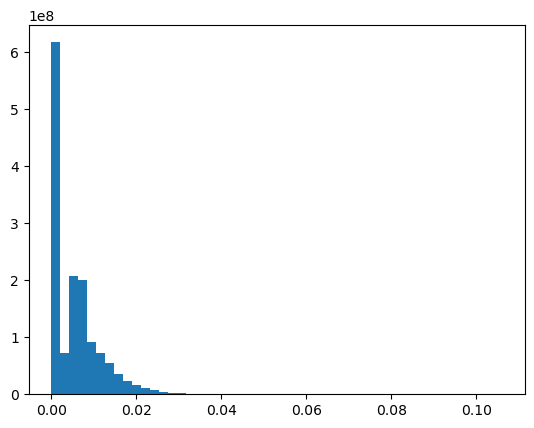

In [51]:
plt.hist(np.abs(similarities_count_morgan3_16392 - similarities_count_morgan3).reshape(-1), bins=50)

In [54]:
idx = np.where(np.abs(similarities_count_morgan3_16392 - similarities_count_morgan3) > 0.1)
idx

(array([ 1336, 10750, 24464, 33226]), array([10750,  1336, 33226, 24464]))

0.16666666666666666 0.2727272727272727


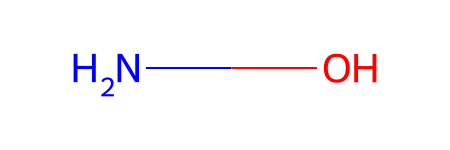

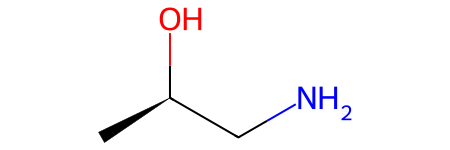

0.16666666666666666 0.2727272727272727


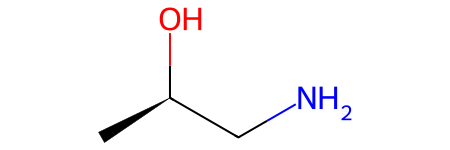

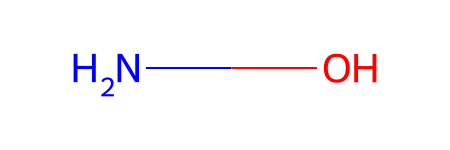

0.3333333333333333 0.23076923076923078


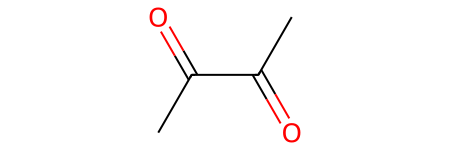

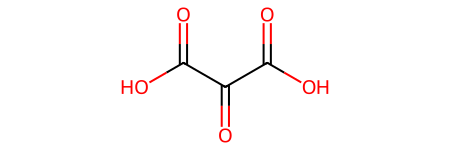

0.3333333333333333 0.23076923076923078


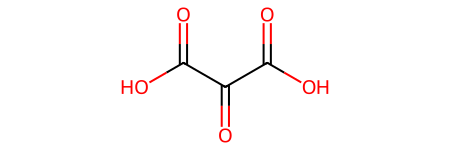

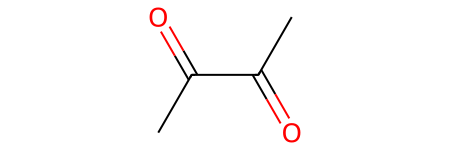

In [56]:
from rdkit import Chem
from rdkit.Chem import Draw


for i in range(len(idx[0])):
    m = idx[0][i]
    n = idx[1][i]
    smiles1 = compounds.smiles[indices_selected[m]]
    smiles2 = compounds.smiles[indices_selected[n]]
    print(similarities_count_morgan3_16392[m, n], similarities_count_morgan3[m, n]) 
    mol = Chem.MolFromSmiles(smiles1)
    display(mol)
    mol = Chem.MolFromSmiles(smiles2)
    display(mol)

In [23]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem


fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096)

fp_generator = FingerprintGenerator(fpgen)
count = True

fingerprints = []
for inchikey, row in tqdm(compounds.iterrows(), total=len(compounds)):
    fp = fp_generator.fingerprint_from_smiles(row.smiles, count)
    if fp is None:
        print(f"Missing fingerprint for {inchikey}: {row.smiles}")
    else:
        fingerprints.append(fp)

fingerprints_morgan6 = np.vstack(fingerprints)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [24]:
%%time

fingerprints_selected = fingerprints_morgan6[indices_selected]
similarities_count_morgan6 = compute_ruzicka_similarities(fingerprints_selected)

CPU times: user 1h 15min 3s, sys: 7.78 s, total: 1h 15min 11s
Wall time: 2min 33s


In [56]:
%%time

similarities_count_morgan6_log = compute_ruzicka_similarities_log(fingerprints_selected)

CPU times: user 9min 25s, sys: 700 ms, total: 9min 26s
Wall time: 23.7 s


In [15]:
similarities_count_morgan3[:10, :5]

array([[1.        , 0.04830918, 0.06134969, 0.05177994, 0.04069767],
       [0.04830918, 1.        , 0.11111111, 0.03225806, 0.09574468],
       [0.06134969, 0.11111111, 1.        , 0.03703704, 0.13286713],
       [0.05177994, 0.03225806, 0.03703704, 1.        , 0.0228013 ],
       [0.04069767, 0.09574468, 0.13286713, 0.0228013 , 1.        ],
       [0.57627119, 0.05445545, 0.05625   , 0.05245902, 0.02941176],
       [0.06818182, 0.12565445, 0.14      , 0.03858521, 0.16447368],
       [0.22222222, 0.10344828, 0.08029197, 0.04895105, 0.08450704],
       [0.07006369, 0.08938547, 0.15267176, 0.05208333, 0.07534247],
       [0.03645833, 0.11881188, 0.12345679, 0.04375   , 0.10588235]])

In [22]:
similarities_count_morgan6[:10, :5]

array([[1.        , 0.03289474, 0.04888889, 0.03508772, 0.03404255],
       [0.03289474, 1.        , 0.08870968, 0.0305499 , 0.07782101],
       [0.04888889, 0.08870968, 1.        , 0.03381643, 0.11173184],
       [0.03508772, 0.0305499 , 0.03381643, 1.        , 0.02112676],
       [0.03404255, 0.07782101, 0.11173184, 0.02112676, 1.        ],
       [0.4673913 , 0.04109589, 0.04147465, 0.03820225, 0.03097345],
       [0.05220884, 0.10037175, 0.10659898, 0.02714932, 0.125     ],
       [0.15422886, 0.07692308, 0.06214689, 0.03414634, 0.07734807],
       [0.05855856, 0.07171315, 0.11695906, 0.03640777, 0.05882353],
       [0.03187251, 0.09328358, 0.1025641 , 0.03440367, 0.08823529]])

In [41]:
#from utils import remove_diagonal

def remove_diagonal(A):
    m = A.shape[0]
    strided = np.lib.stride_tricks.as_strided
    s0,s1 = A.strides
    return strided(A.ravel()[1:], shape=(m-1,m), strides=(s0+s1,s1)).reshape(m,-1)



def compare_distributions(
    similarities1,
    similarities2,
    label1,
    label2,
    title="",
    ignore_diagonal=True
):
    if ignore_diagonal:
        similarities1 = remove_diagonal(similarities1)
        similarities2 = remove_diagonal(similarities2)

    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.hist(similarities1.reshape(-1),
                    bins=50, rwidth=0.8, alpha=0.5, label=label1)
    ax.hist(similarities2.reshape(-1),
                    bins=50, rwidth=0.8, alpha=0.5, label=label2)
    ax.set_title(title)
    ax.set_xlabel("Tanimoto(-like) score")
    ax.set_ylabel("Score counts")
    
    ax.set_yscale("log")
    ax.set_yscale("log")
    plt.legend()
    plt.show()

In [44]:
A = np.random.randint(0, 10, (10, 10))
A

array([[6, 6, 3, 0, 2, 7, 4, 0, 6, 2],
       [3, 7, 8, 1, 0, 5, 0, 3, 9, 2],
       [8, 6, 9, 1, 8, 5, 1, 1, 2, 9],
       [0, 7, 1, 9, 2, 6, 4, 5, 2, 8],
       [9, 0, 3, 0, 8, 2, 1, 5, 9, 7],
       [6, 5, 8, 1, 0, 6, 1, 6, 8, 8],
       [0, 3, 6, 8, 4, 8, 3, 1, 4, 8],
       [8, 5, 5, 2, 2, 4, 6, 3, 8, 4],
       [8, 0, 4, 8, 3, 1, 6, 7, 4, 7],
       [4, 3, 5, 9, 2, 8, 6, 3, 5, 0]])

In [45]:
remove_diagonal(A)

array([[6, 3, 0, 2, 7, 4, 0, 6, 2],
       [3, 8, 1, 0, 5, 0, 3, 9, 2],
       [8, 6, 1, 8, 5, 1, 1, 2, 9],
       [0, 7, 1, 2, 6, 4, 5, 2, 8],
       [9, 0, 3, 0, 2, 1, 5, 9, 7],
       [6, 5, 8, 1, 0, 1, 6, 8, 8],
       [0, 3, 6, 8, 4, 8, 1, 4, 8],
       [8, 5, 5, 2, 2, 4, 6, 8, 4],
       [8, 0, 4, 8, 3, 1, 6, 7, 7],
       [4, 3, 5, 9, 2, 8, 6, 3, 5]])

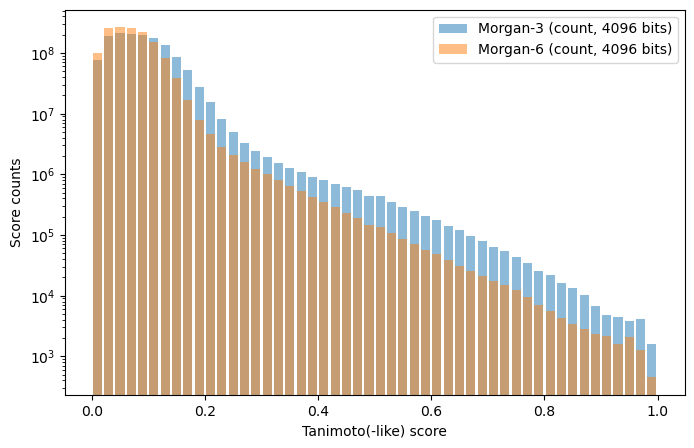

In [26]:
NBITS = 4096

compare_distributions(similarities_count_morgan3,
                      similarities_count_morgan6,
                      f"Morgan-3 (count, {NBITS} bits)",
                      f"Morgan-6 (count, {NBITS} bits)",
)

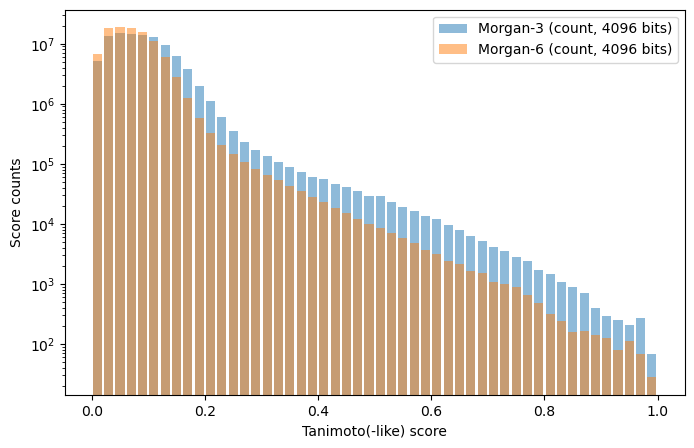

In [23]:
NBITS = 4096

compare_distributions(similarities_count_morgan3,
                      similarities_count_morgan6,
                      f"Morgan-3 (count, {NBITS} bits)",
                      f"Morgan-6 (count, {NBITS} bits)",
)

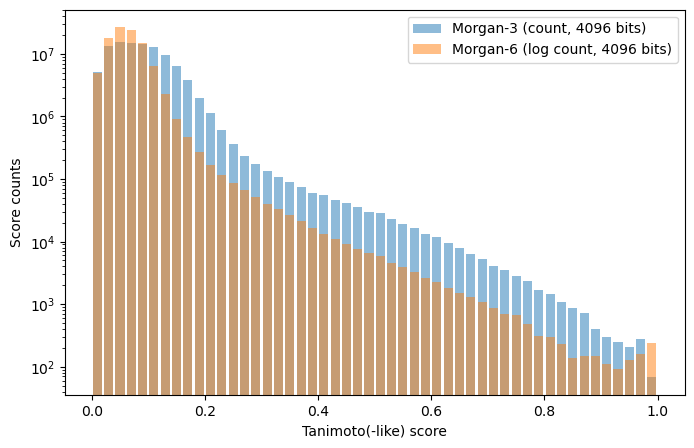

In [83]:
NBITS = 4096

compare_distributions(similarities_count_morgan3,
                      similarities_count_morgan6_log,
                      f"Morgan-3 (count, {NBITS} bits)",
                      f"Morgan-6 (log count, {NBITS} bits)",
)

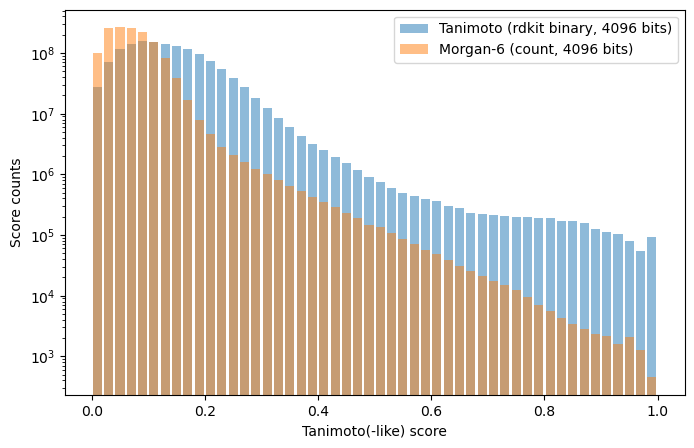

In [29]:
NBITS = 4096

compare_distributions(similarities_classic,
                      similarities_count_morgan6,
                      f"Tanimoto (rdkit binary, {NBITS} bits)",
                      f"Morgan-6 (count, {NBITS} bits)",
)

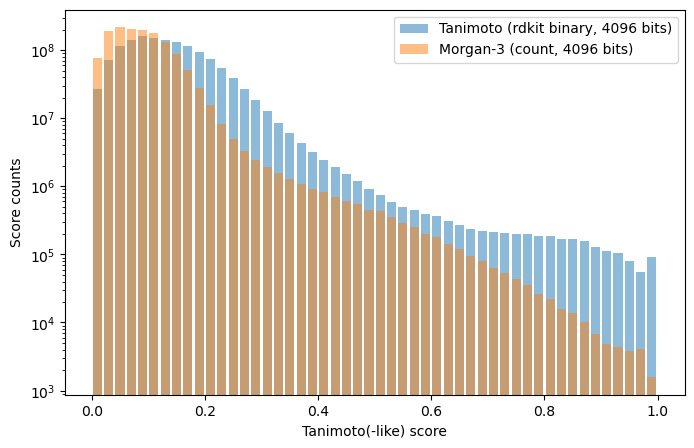

In [42]:
NBITS = 4096

compare_distributions(
    similarities_classic,
    similarities_count_morgan3,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Morgan-3 (count, {NBITS} bits)",
    ignore_diagonal=True,
)

In [60]:
idx0.shape[0], idx1.shape[0]

(5280, 20714)

In [71]:
log_positions

array([  1.        ,   1.66810054,   2.7825594 ,   4.64158883,
         7.74263683,  12.91549665,  21.5443469 ,  35.93813664,
        59.94842503, 100.        ])

8578 8525


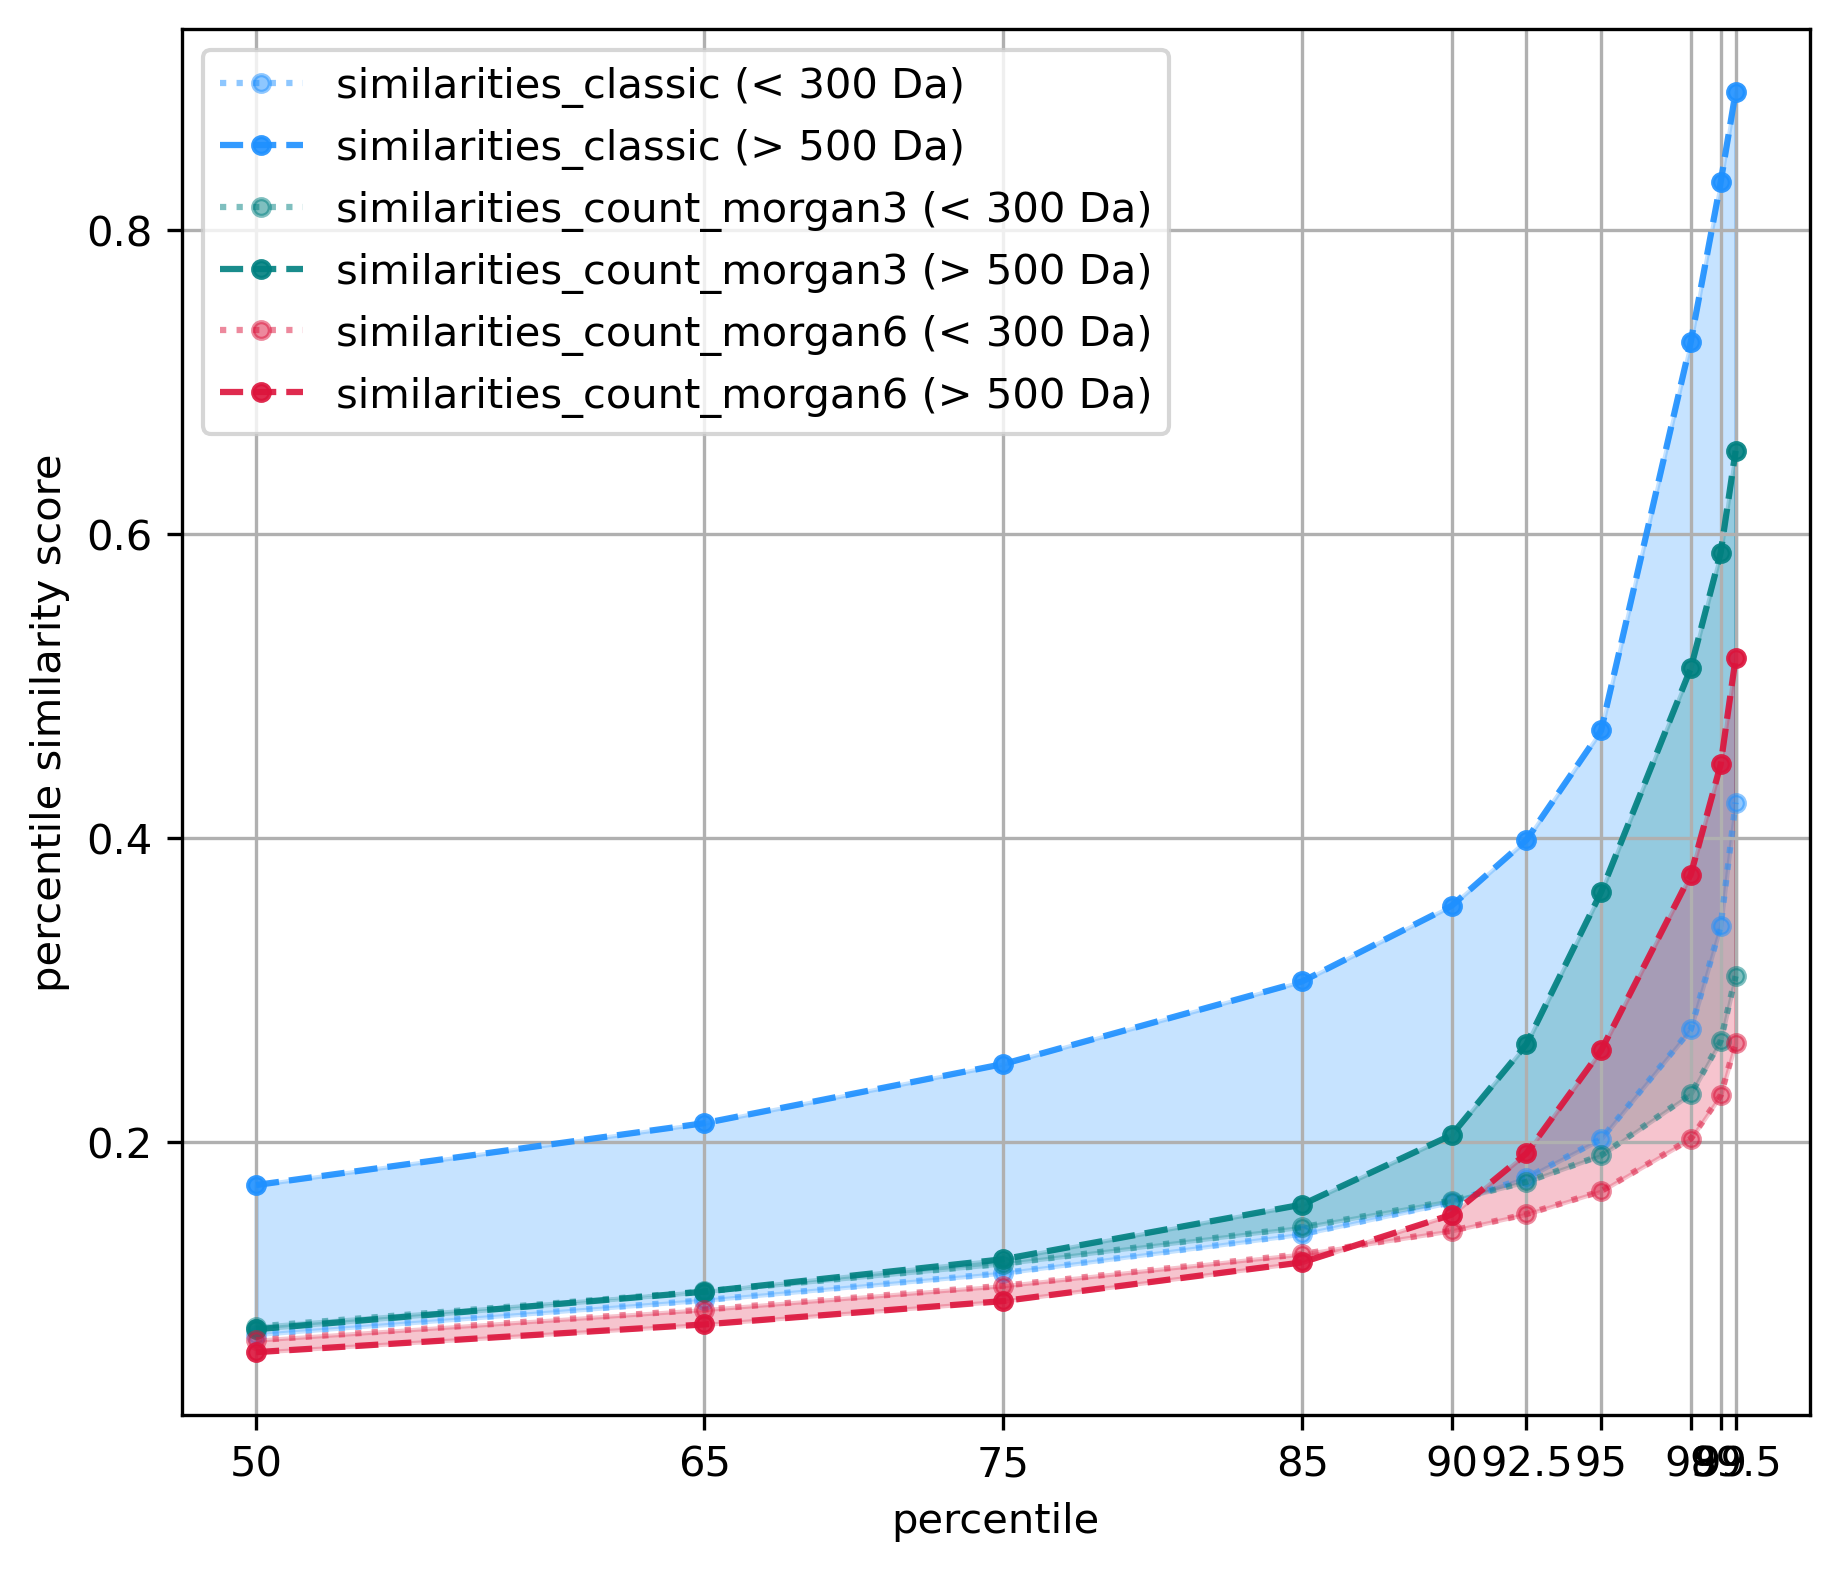

In [103]:
#percentiles = np.arange(0, 101)
percentiles = [50, 65, 75, 85, 90, 92.5, 95, 98, 99, 99.5] #, 99.9]

mass_low = 300
mass_high = 500

idx1 = np.where(compounds.mass[indices_selected] > mass_high)[0]
idx0 = np.where(compounds.mass[indices_selected] < mass_low)[0]
print(idx0.shape[0], idx1.shape[0])

# Compare selected percentiles
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=300)

similarities_dict = {
    "similarities_classic": similarities_classic,
    "similarities_count_morgan3": similarities_count_morgan3,
    "similarities_count_morgan6": similarities_count_morgan6,
}


colors = ["dodgerblue", "teal", "crimson"]

curves =  {key: {} for key, _ in similarities_dict.items()}

for i, (key, similarities) in enumerate(similarities_dict.items()):
    percentile_scores = np.percentile(similarities[np.ix_(idx0, idx0)].reshape(-1), percentiles)
    curves[key][mass_low] = percentile_scores
    ax.plot(percentiles, percentile_scores, ".:", markersize=8, label=key+f" (< {mass_low} Da)", color=colors[i], alpha=0.5)

    percentile_scores = np.percentile(similarities[np.ix_(idx1, idx1)].reshape(-1), percentiles)
    curves[key][mass_high] = percentile_scores
    ax.plot(percentiles, percentile_scores, ".--", markersize=8, label=key+f" (> {mass_high} Da)", color=colors[i],  alpha=0.9)

for i, (key, similarities) in enumerate(similarities_dict.items()):
    ax.fill_between(percentiles, curves[key][mass_low], curves[key][mass_high], color=colors[i], alpha=0.25)

ax.set_xticks(percentiles, [str(x) for x in percentiles])
ax.grid(True)
ax.set_xlabel("percentile")
ax.set_ylabel("percentile similarity score")

plt.legend()

8578 8525


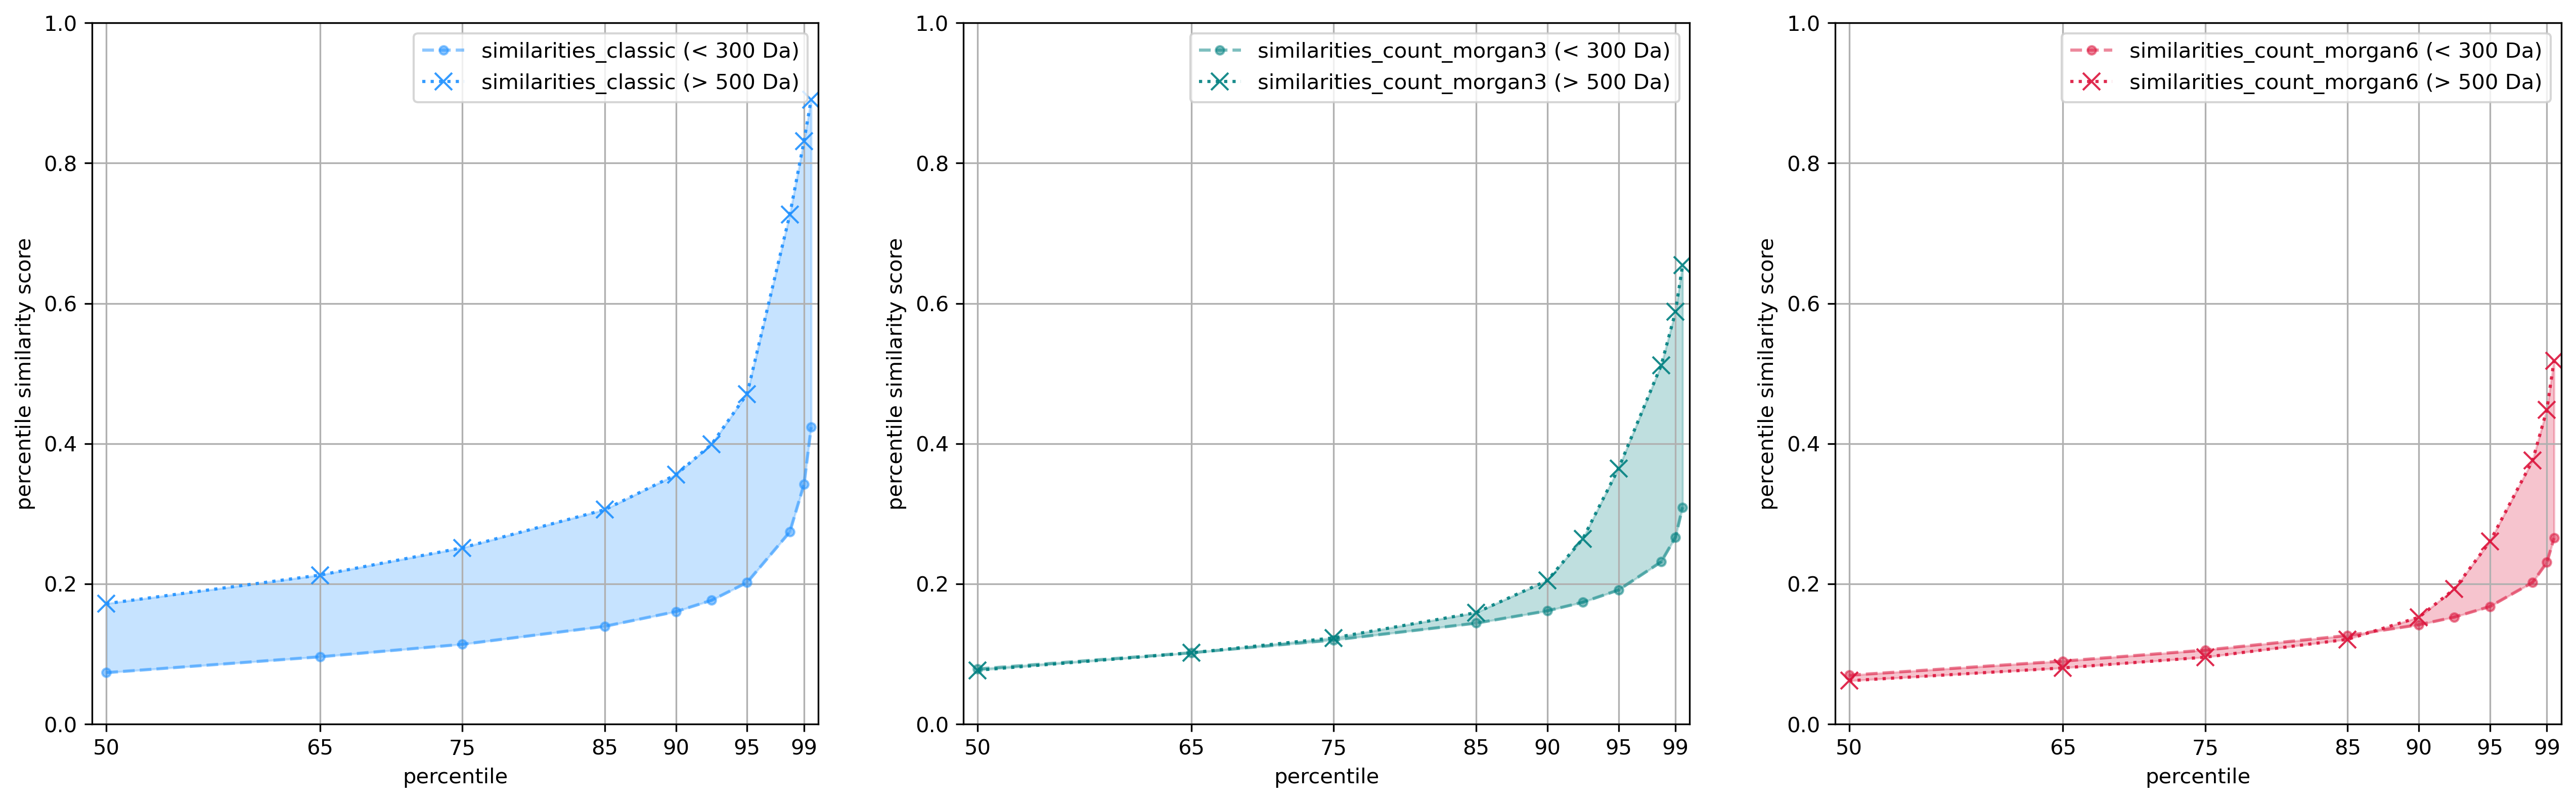

In [110]:
#percentiles = np.arange(0, 101)
percentiles = [50, 65, 75, 85, 90, 92.5, 95, 98, 99, 99.5] #, 99.9]
percentiles_ticks = [50, 65, 75, 85, 90, 95, 99]

mass_low = 300
mass_high = 500

idx1 = np.where(compounds.mass[indices_selected] > mass_high)[0]
idx0 = np.where(compounds.mass[indices_selected] < mass_low)[0]
print(idx0.shape[0], idx1.shape[0])

# Compare selected percentiles
fig, axes = plt.subplots(1, 3, figsize=(21, 6), dpi=300)

similarities_dict = {
    "similarities_classic": similarities_classic,
    "similarities_count_morgan3": similarities_count_morgan3,
    "similarities_count_morgan6": similarities_count_morgan6,
}


colors = ["dodgerblue", "teal", "crimson"]

curves =  {key: {} for key, _ in similarities_dict.items()}

for i, (key, similarities) in enumerate(similarities_dict.items()):
    percentile_scores = np.percentile(similarities[np.ix_(idx0, idx0)].reshape(-1), percentiles)
    curves[key][mass_low] = percentile_scores
    axes[i].plot(percentiles, percentile_scores, ".--", markersize=8, label=key+f" (< {mass_low} Da)", color=colors[i], alpha=0.5)

    percentile_scores = np.percentile(similarities[np.ix_(idx1, idx1)].reshape(-1), percentiles)
    curves[key][mass_high] = percentile_scores
    axes[i].plot(percentiles, percentile_scores, "x:", markersize=8, label=key+f" (> {mass_high} Da)", color=colors[i],  alpha=0.9)

for i, (key, similarities) in enumerate(similarities_dict.items()):
    axes[i].fill_between(percentiles, curves[key][mass_low], curves[key][mass_high], color=colors[i], alpha=0.25)

    axes[i].set_xticks(percentiles_ticks, [str(x) for x in percentiles_ticks])
    axes[i].grid(True)
    axes[i].set_xlabel("percentile")
    axes[i].set_ylabel("percentile similarity score")
    axes[i].set_ylim(0, 1)
    axes[i].set_xlim(49, 100)
    axes[i].legend()
    
plt.savefig("fig_low_high_mass_score_percentiles.pdf")
plt.savefig("fig_low_high_mass_score_percentiles.png", dpi=300)
plt.show()

5280 8578


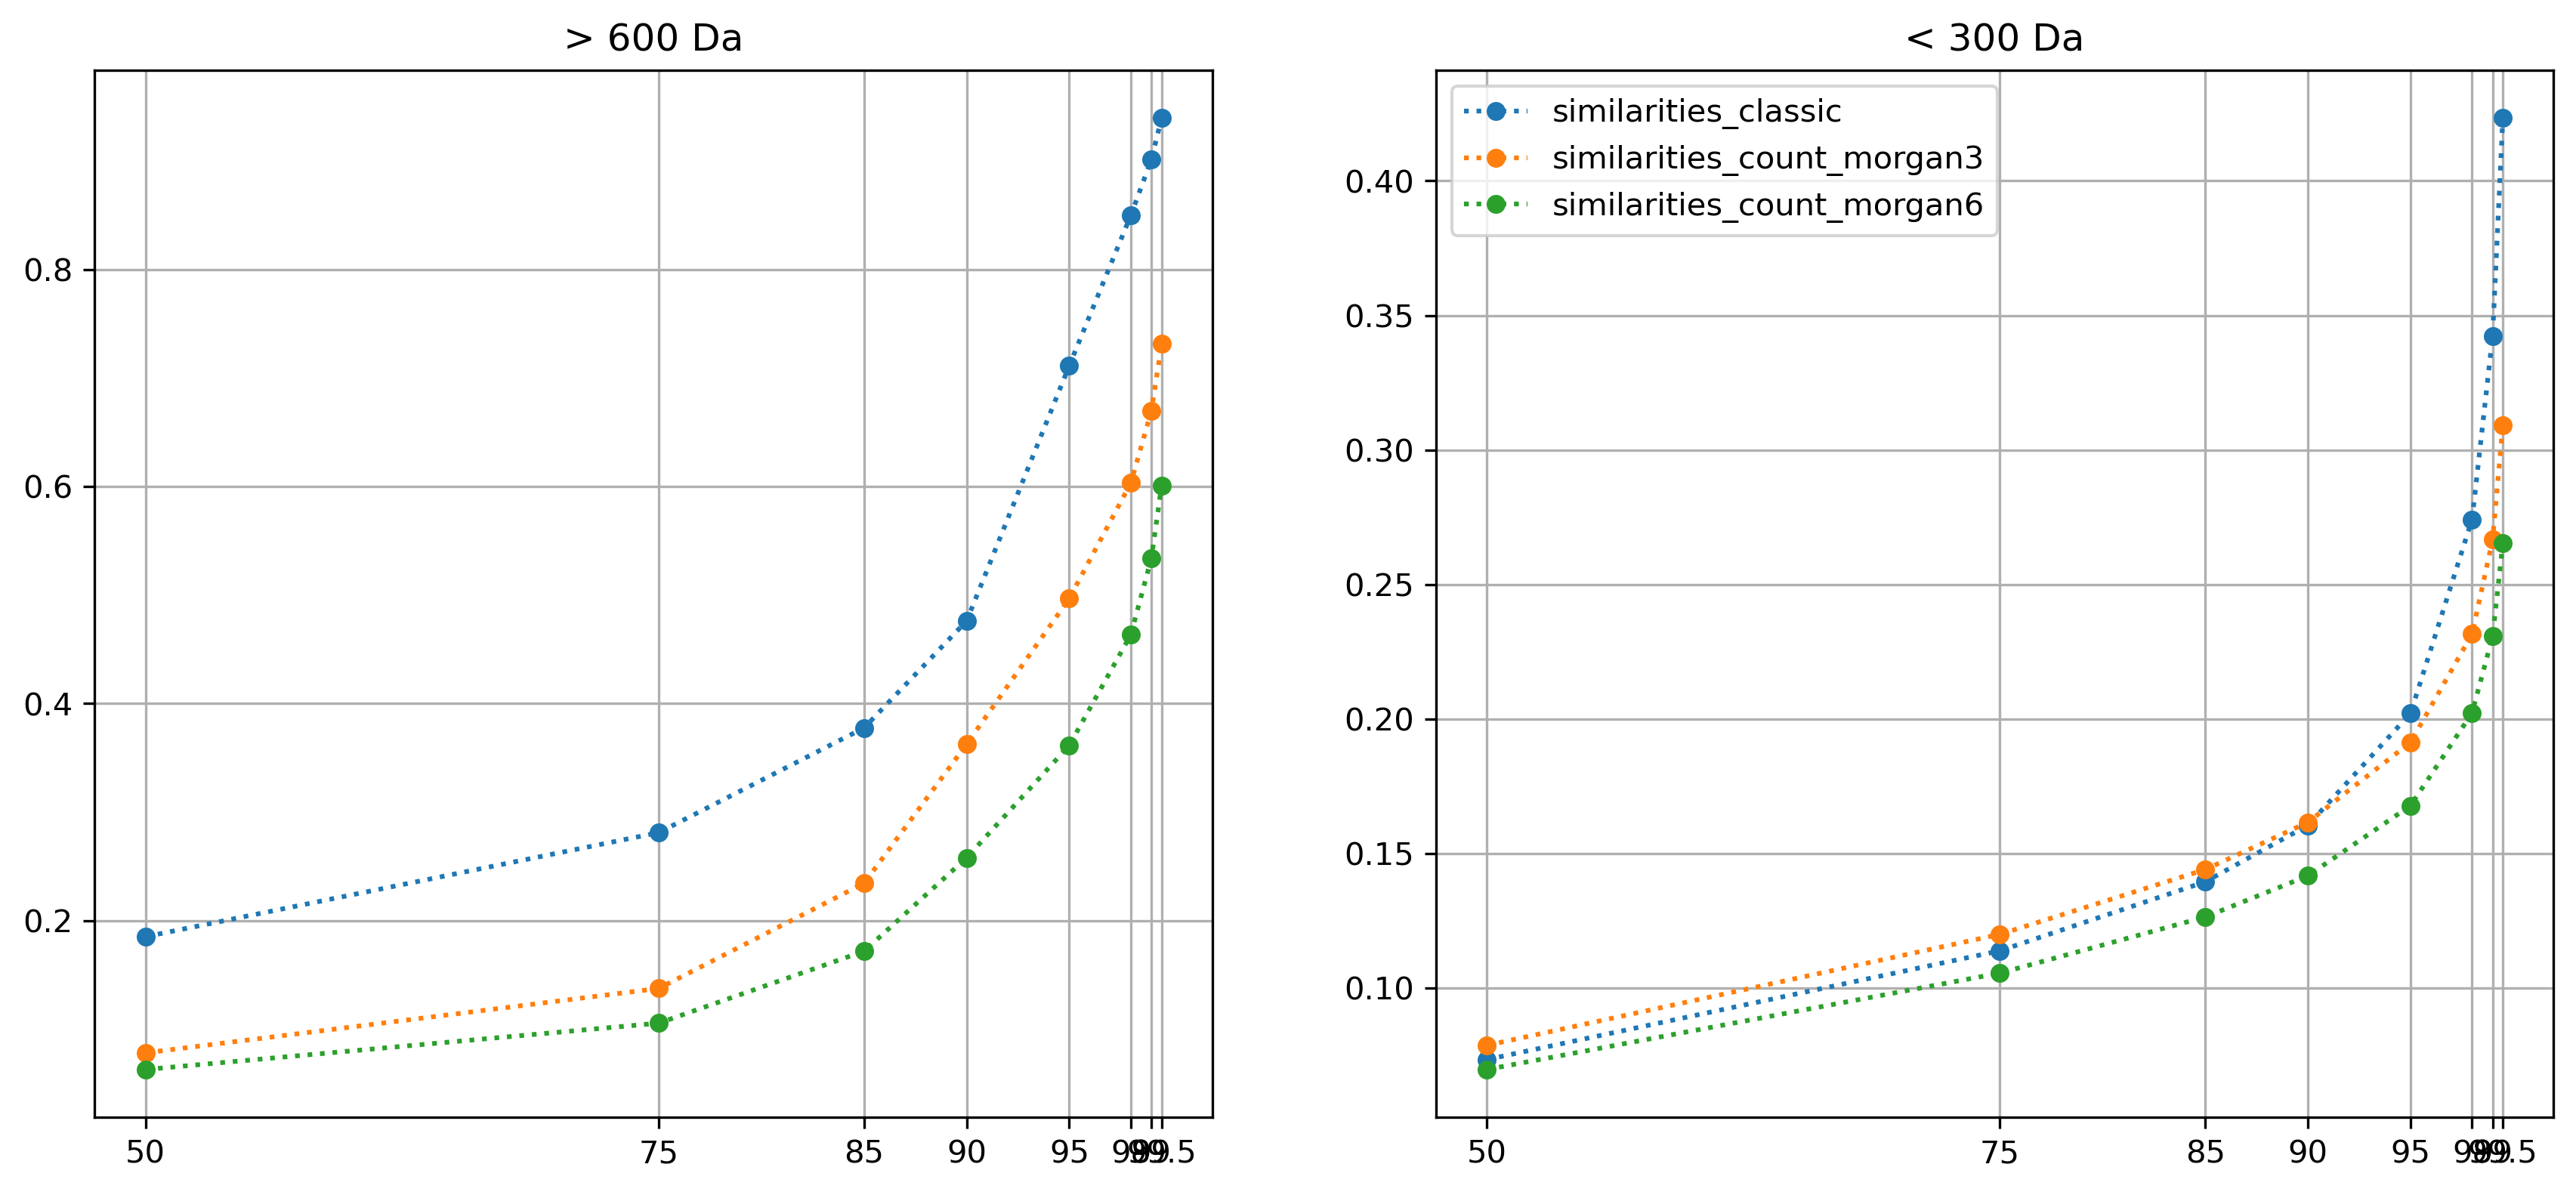

In [86]:
#percentiles = np.arange(0, 101)
percentiles = [50, 75, 85, 90, 95, 98, 99, 99.5] #, 99.9]

mass_low = 300
mass_high = 600

idx0 = np.where(compounds.mass[indices_selected] > mass_high)[0]
idx1 = np.where(compounds.mass[indices_selected] < mass_low)[0]
print(idx0.shape[0], idx1.shape[0])

# Compare selected percentiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

similarities_dict = {
    "similarities_classic": similarities_classic,
    "similarities_count_morgan3": similarities_count_morgan3,
    "similarities_count_morgan6": similarities_count_morgan6,
}

for key, similarities in similarities_dict.items():
    percentile_scores = np.percentile(similarities[np.ix_(idx0, idx0)].reshape(-1), percentiles)
    ax1.plot(percentiles, percentile_scores, ".:", markersize=10, label=key)
    #ax.scatter([str(x) for x in percentiles], percentile_scores, label=key)

ax1.set_title(f"> {mass_high} Da")
ax1.set_xticks(percentiles, [str(x) for x in percentiles])

for key, similarities in similarities_dict.items():
    percentile_scores = np.percentile(similarities[np.ix_(idx1, idx1)].reshape(-1), percentiles)
    ax2.plot(percentiles, percentile_scores, ".:", markersize=10, label=key)
    #ax.scatter([str(x) for x in percentiles], percentile_scores, label=key)

ax2.set_title(f"< {mass_low} Da")
ax2.set_xticks(percentiles, [str(x) for x in percentiles])
ax1.grid(True)
ax2.grid(True)

plt.legend()

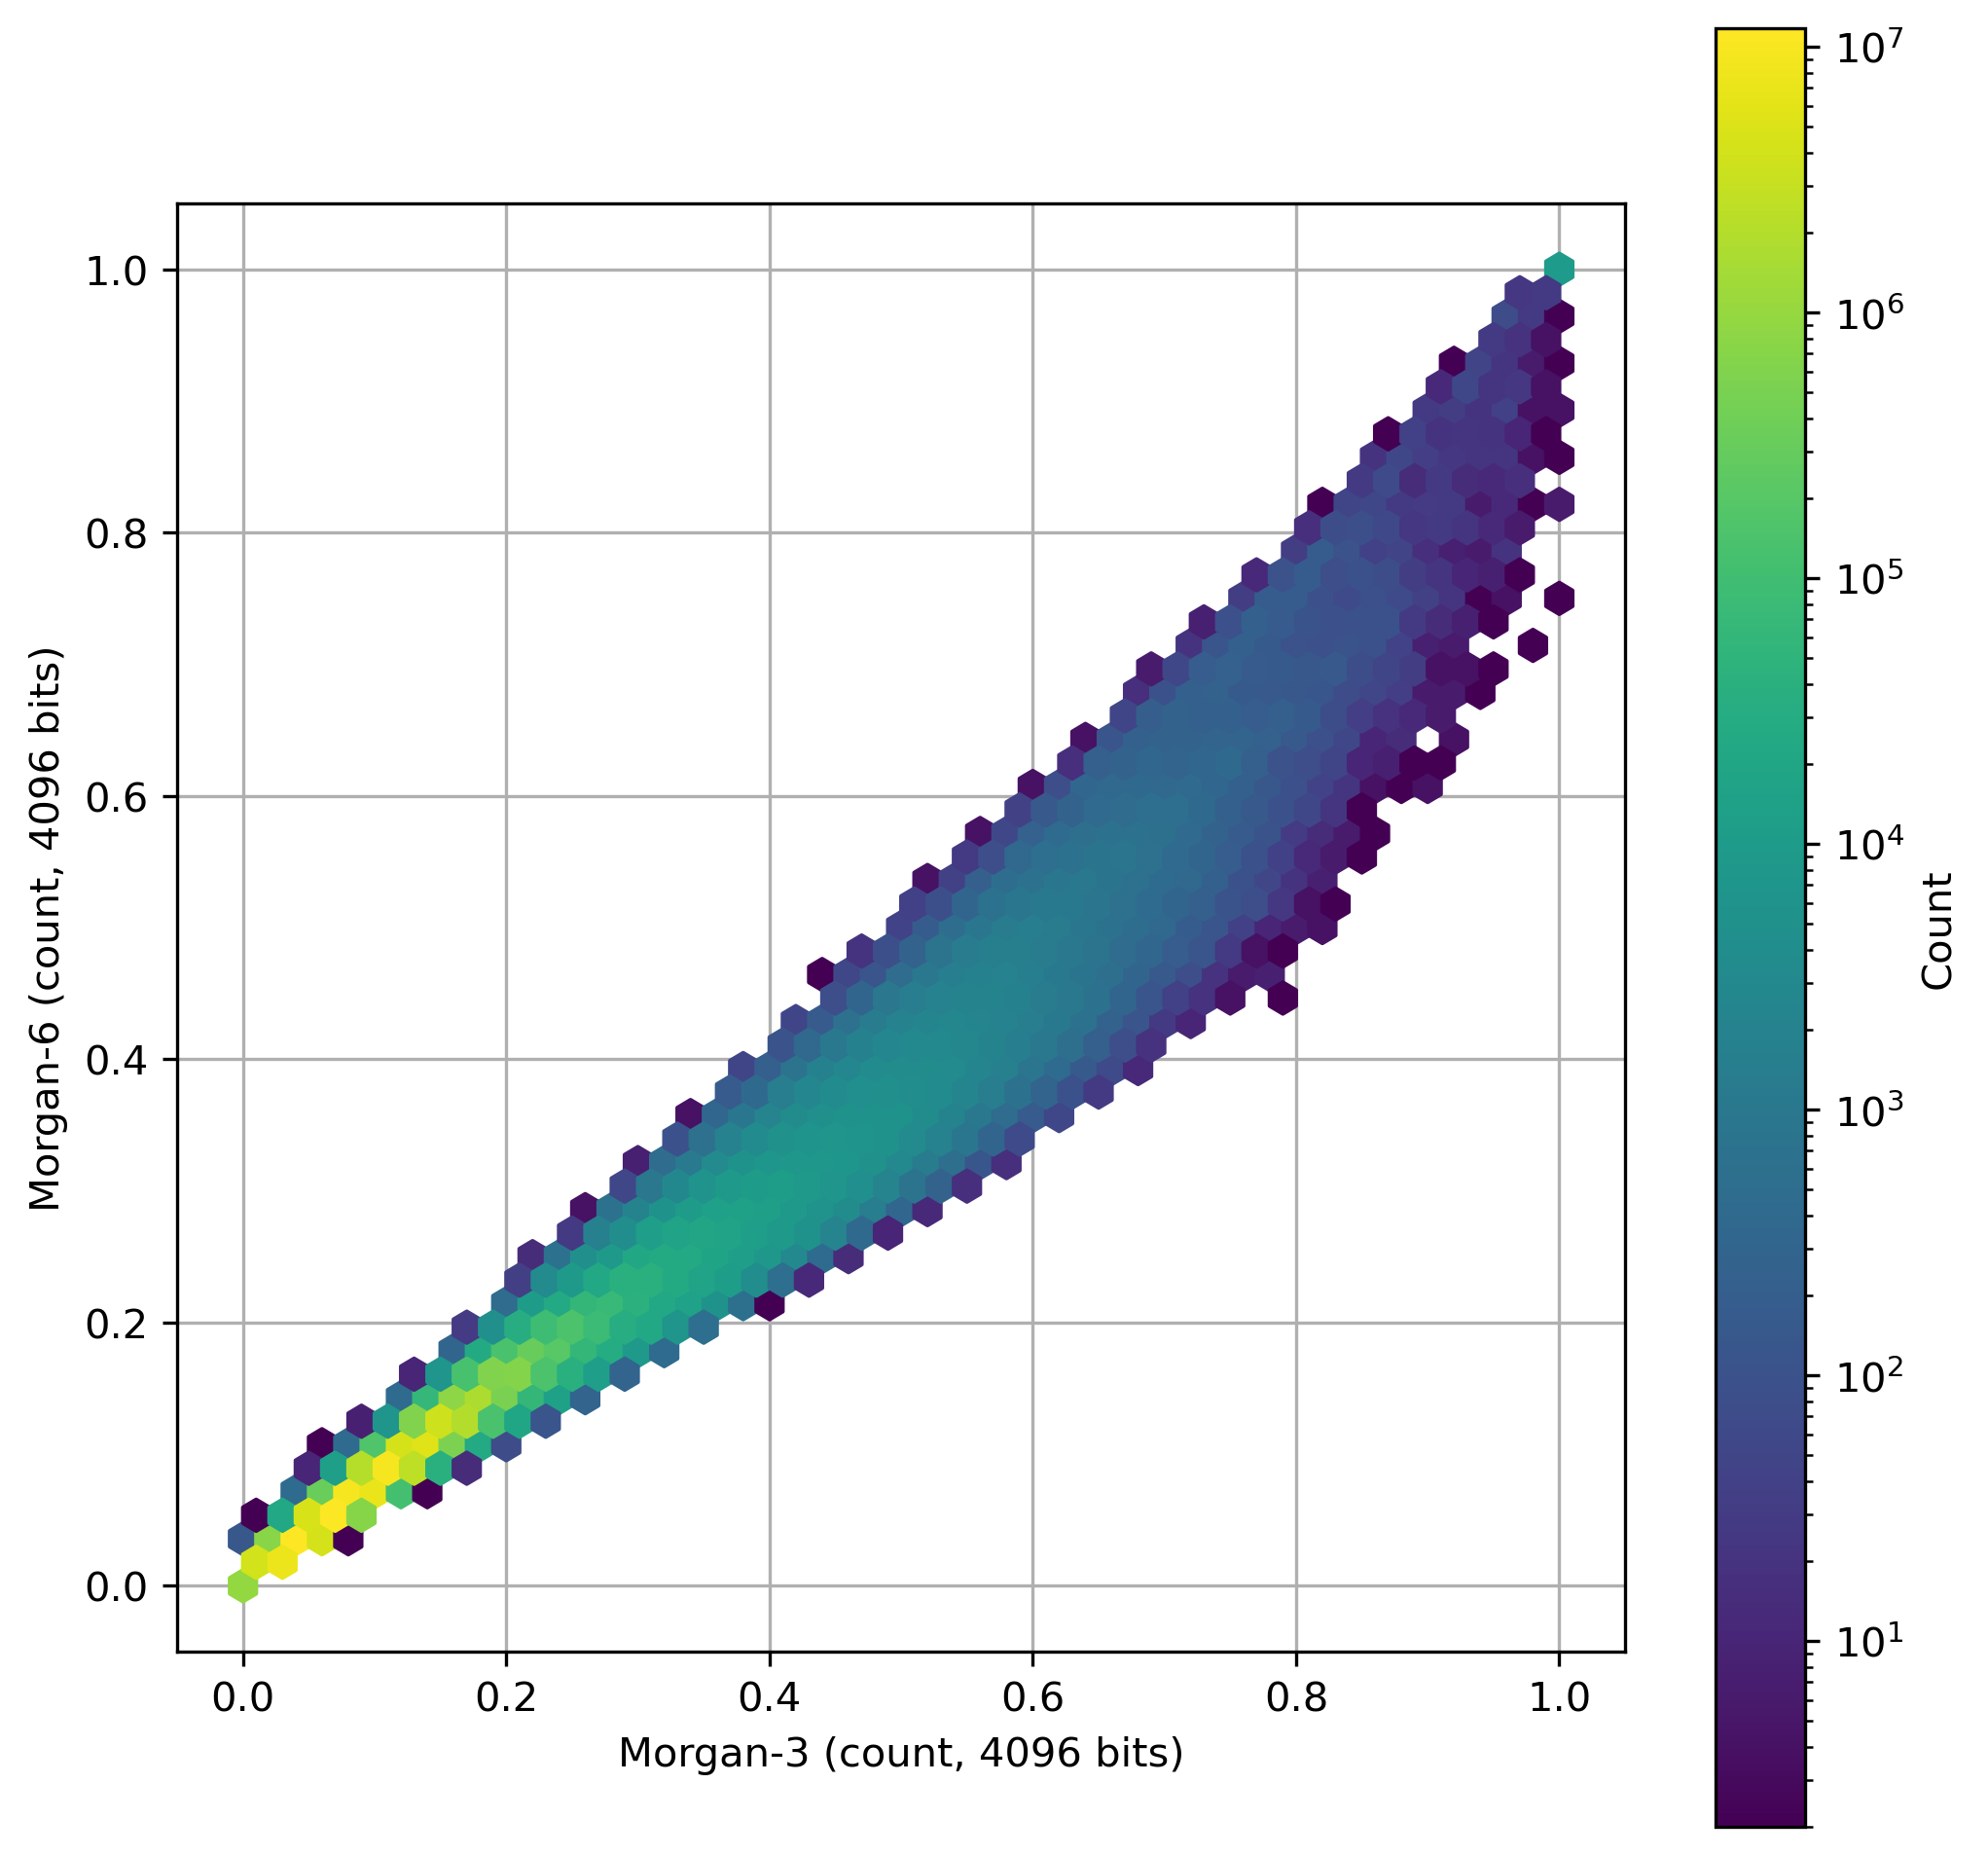

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm


def hex_comparison(similarities1, similarities2, label1, label2):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    hb = ax.hexbin(similarities1.flatten(), similarities2.flatten(),
                   gridsize=50,
                   cmap='viridis',
                   mincnt=1,
                   norm=LogNorm(),
                   zorder=2)
    
    # Add the grid
    ax.grid(True, zorder=1)
    
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Count')
    
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    ax.set_aspect('equal', 'box')
    
    plt.show()


hex_comparison(
    similarities_count,
    similarities_count_morgan6,
    f"Morgan-3 (count, {NBITS} bits)",
    f"Morgan-6 (count, {NBITS} bits)",
)

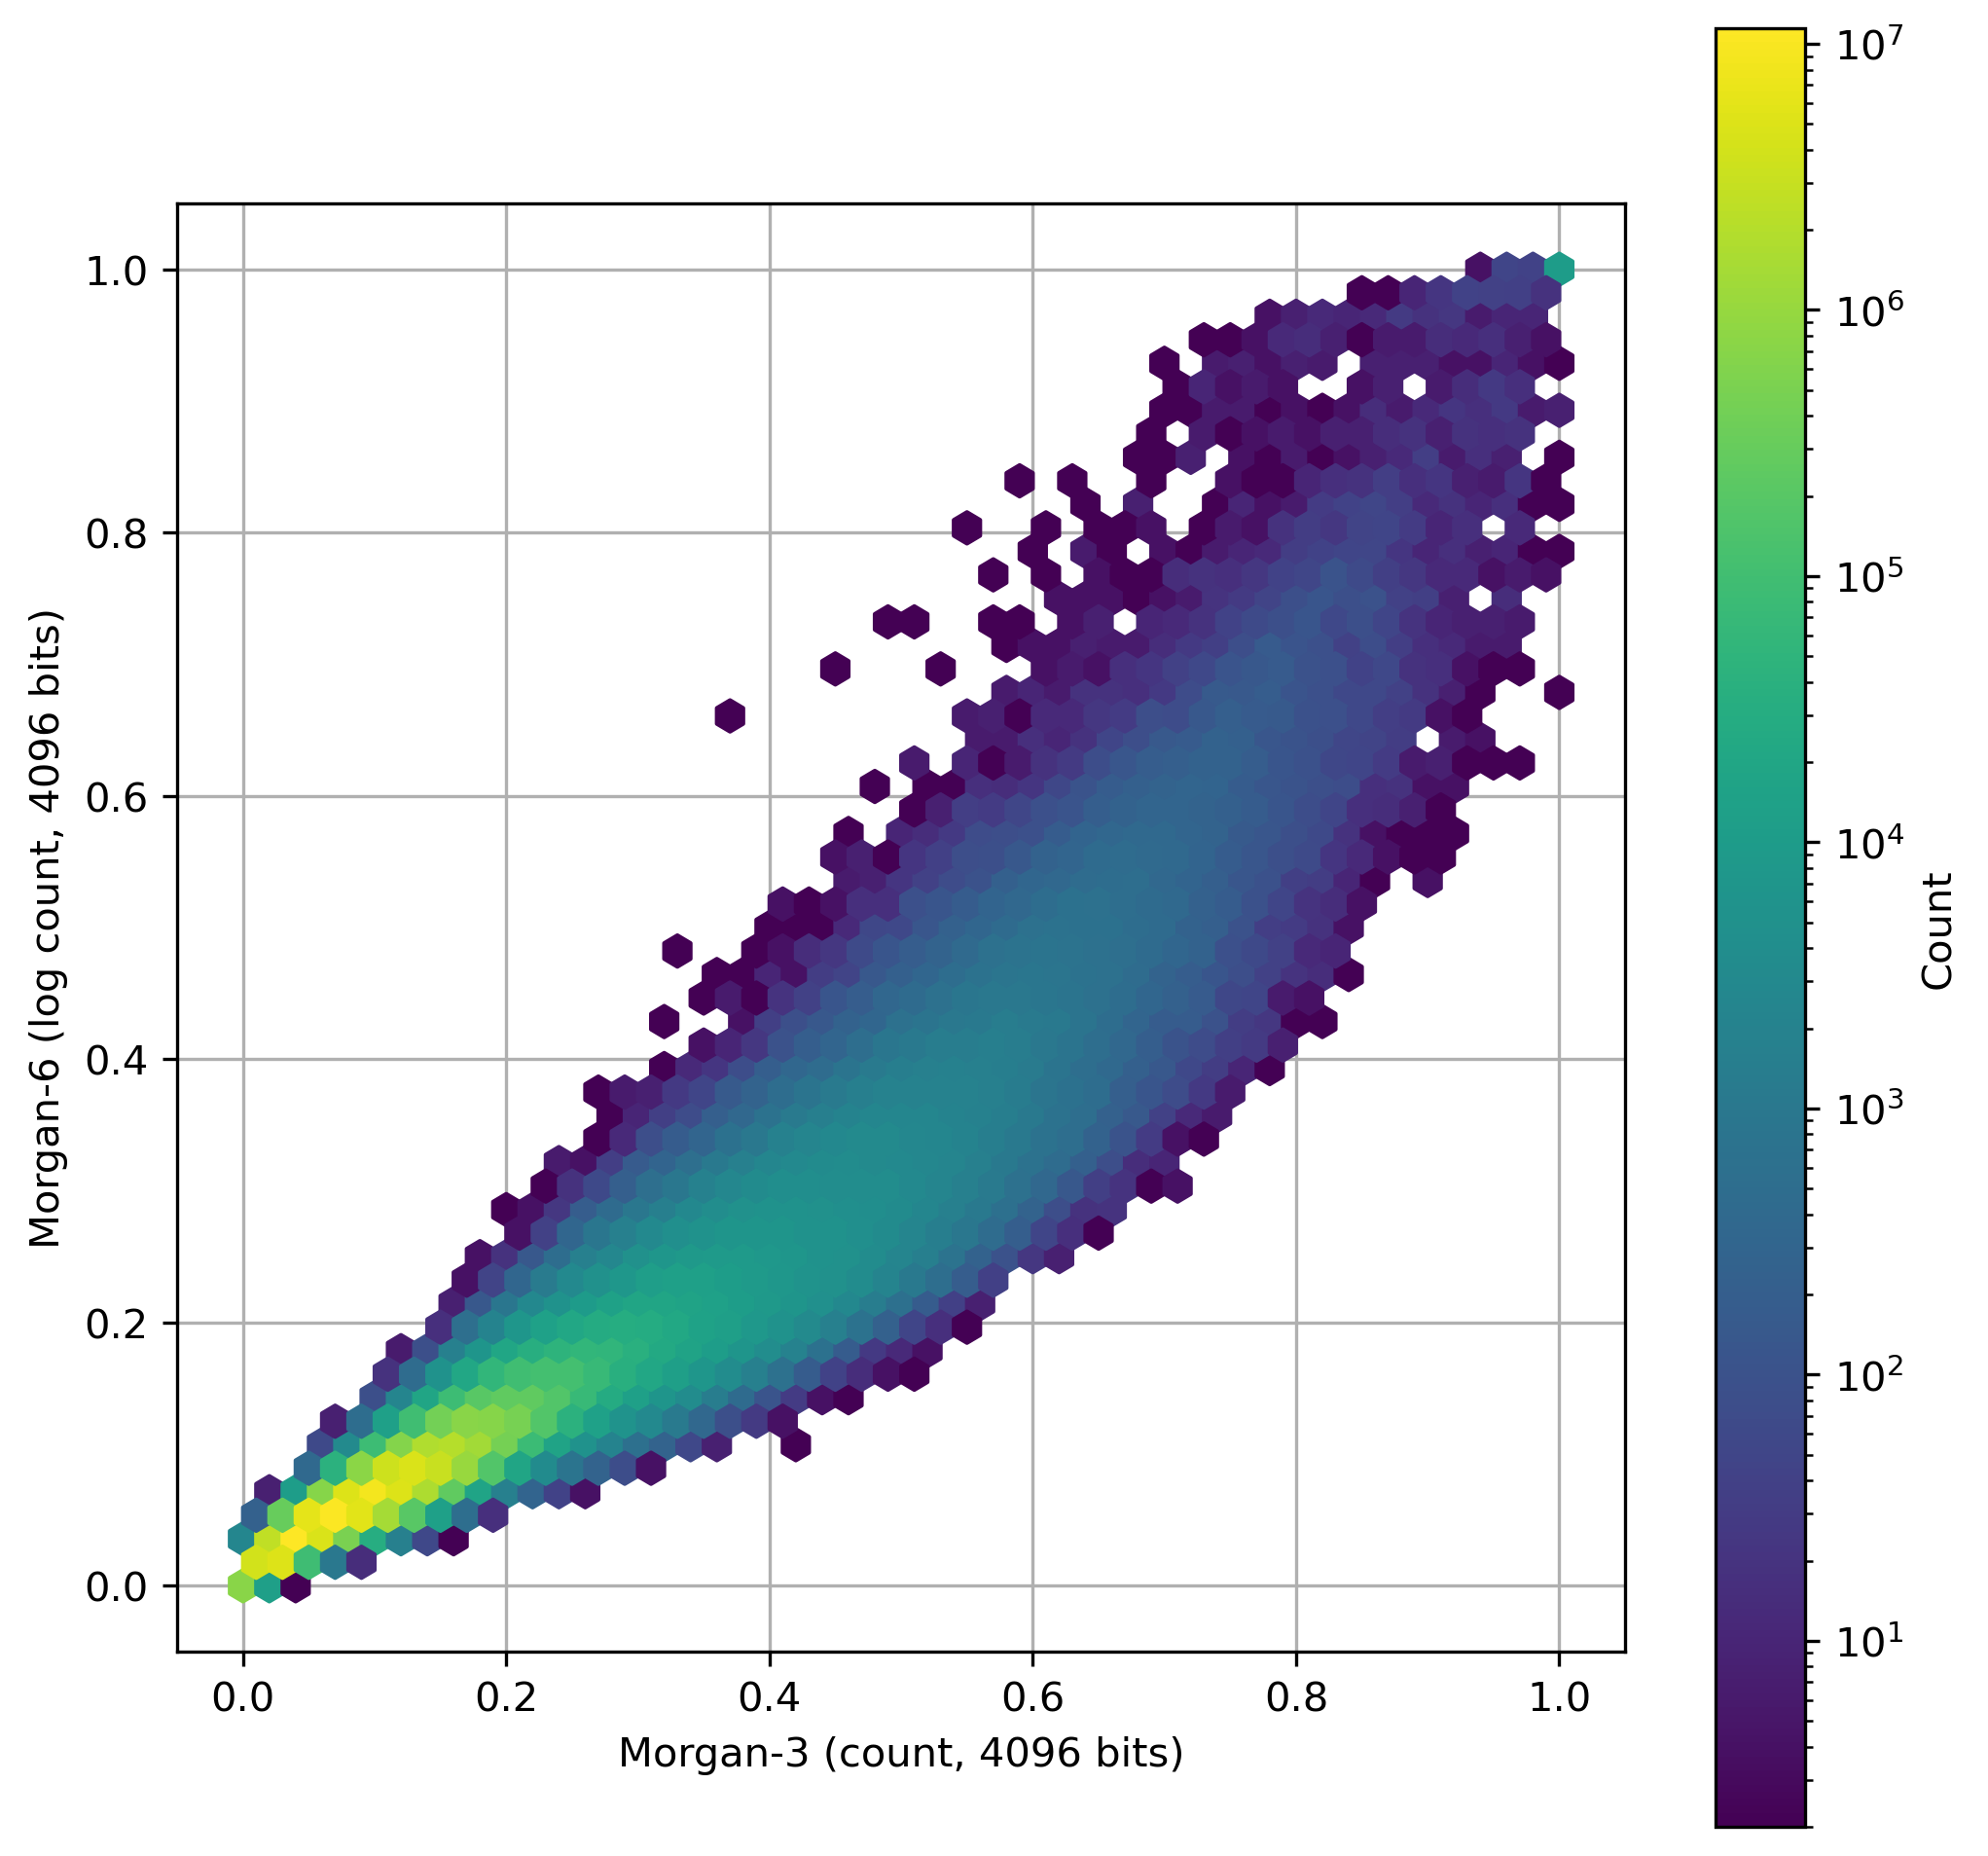

In [61]:
hex_comparison(
    similarities_count,
    similarities_count_morgan6_log,
    f"Morgan-3 (count, {NBITS} bits)",
    f"Morgan-6 (log count, {NBITS} bits)",
)

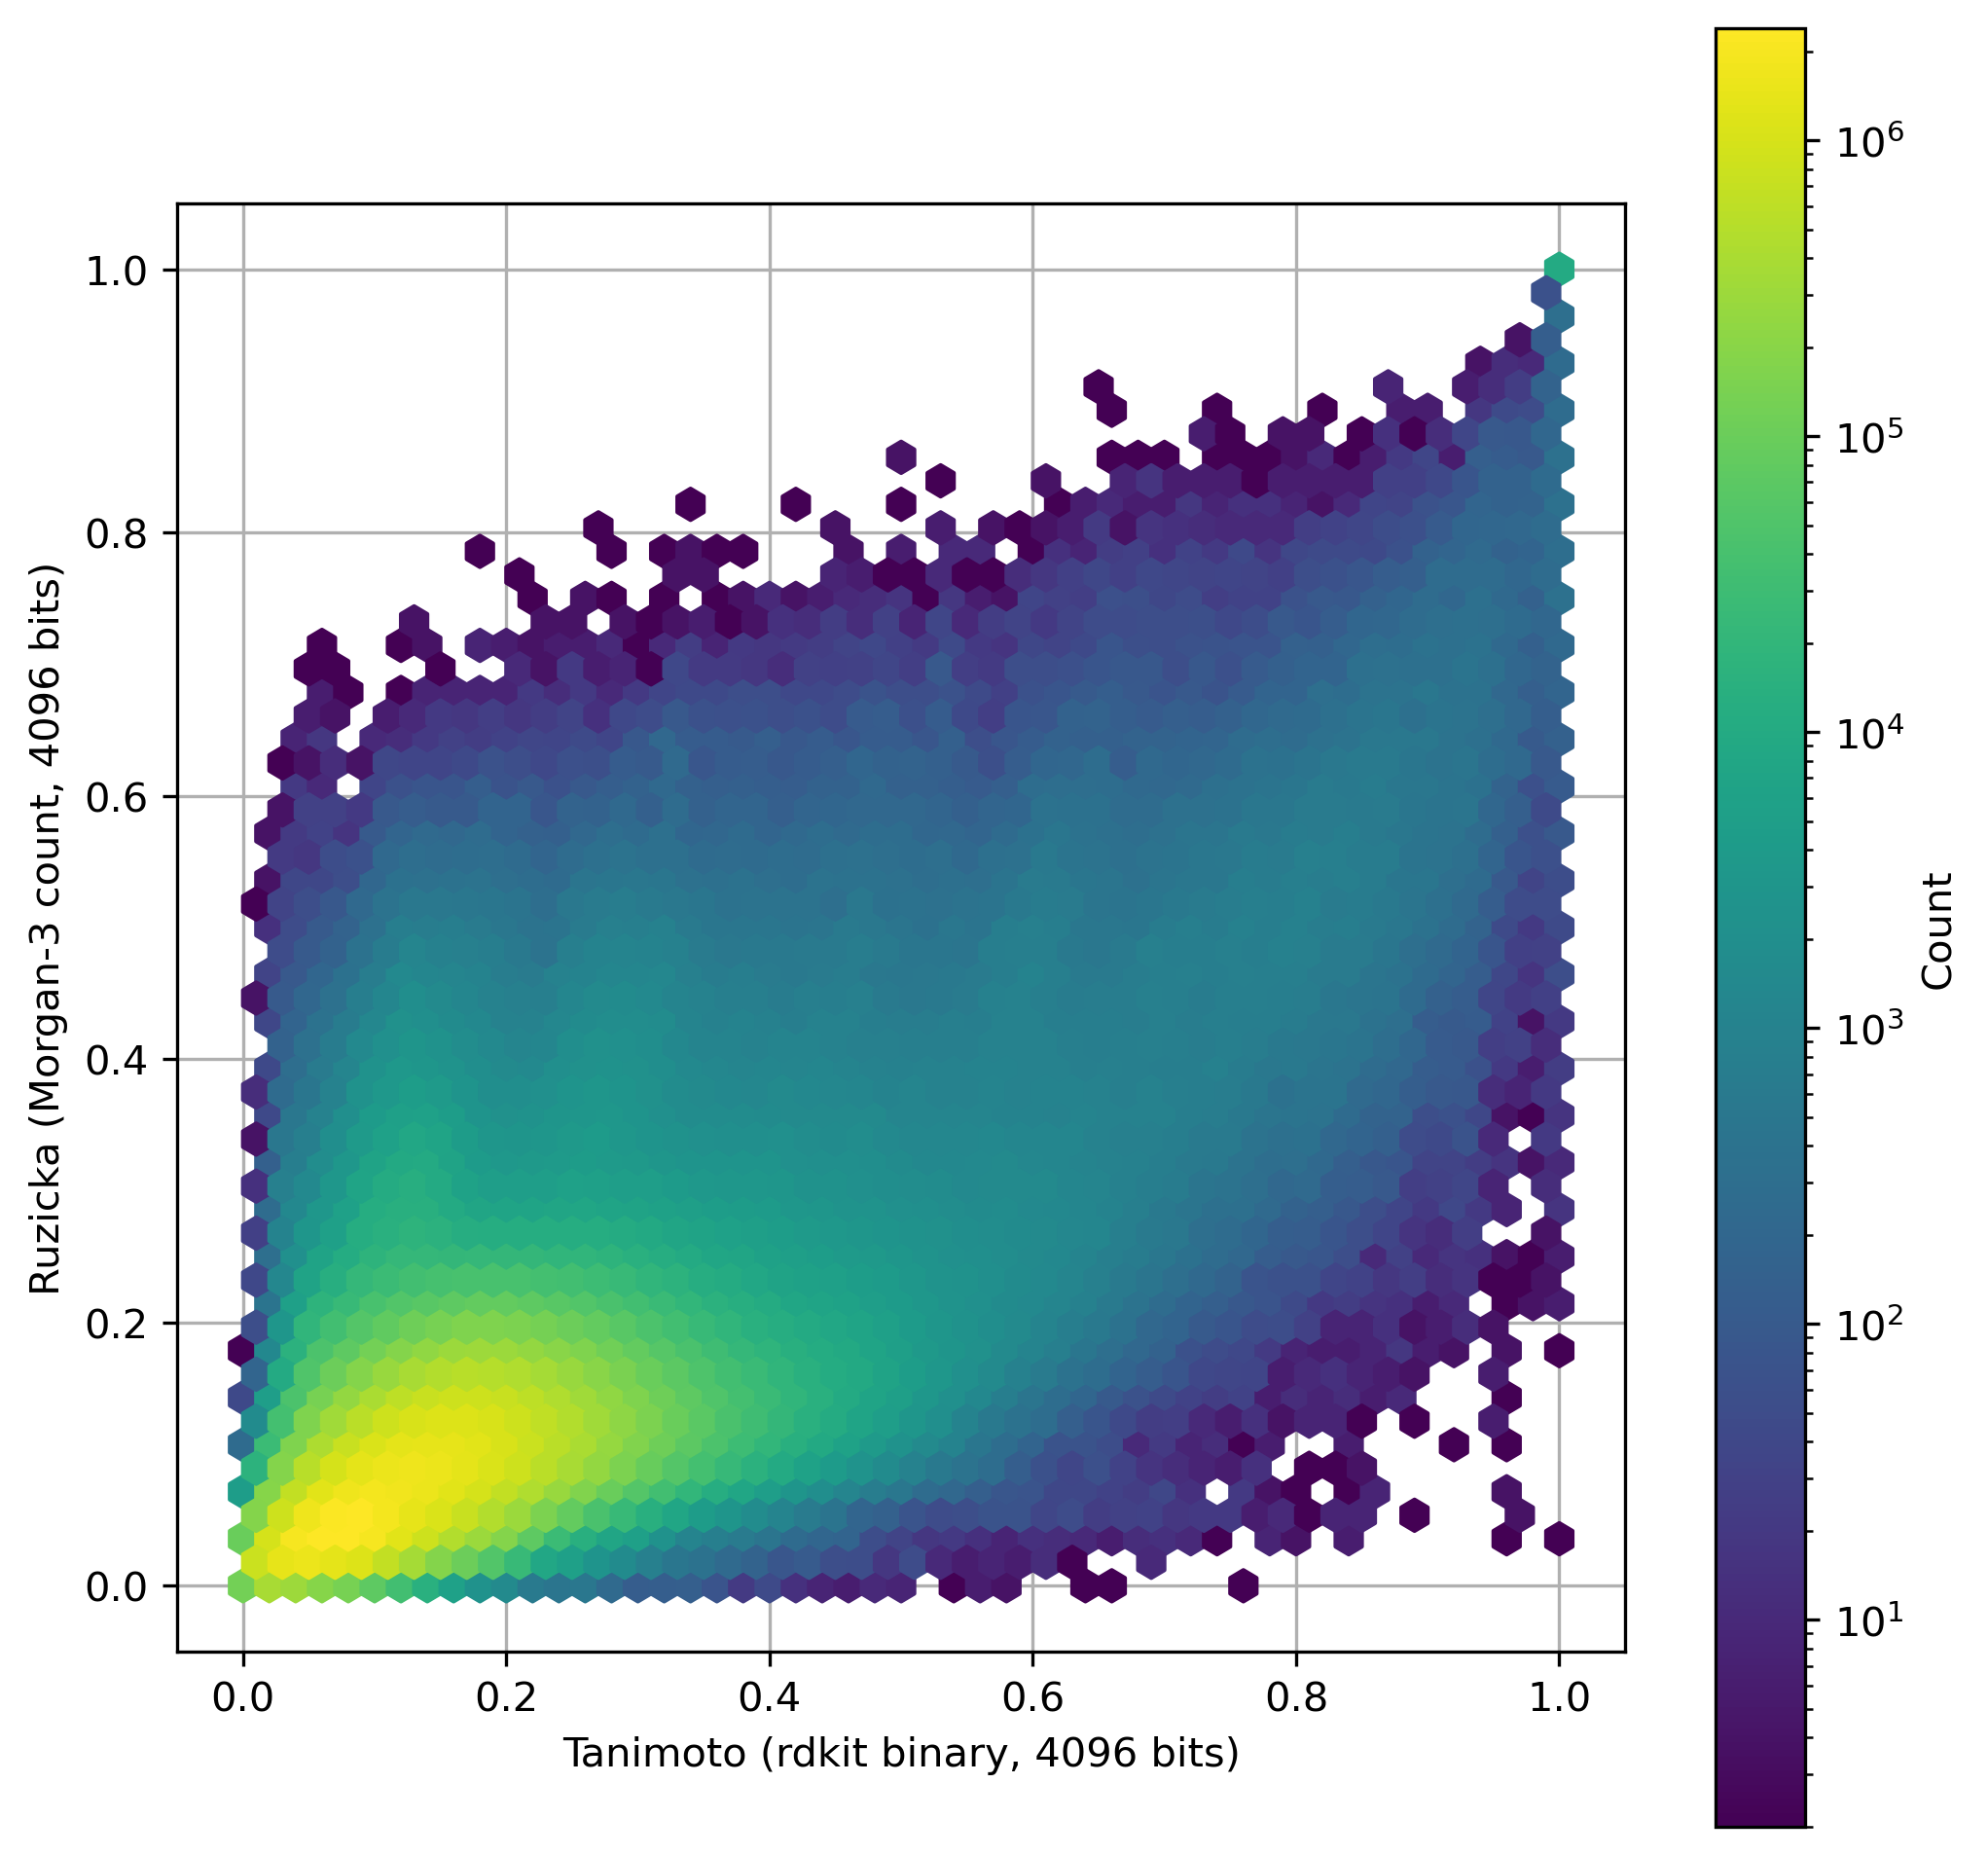

In [103]:
hex_comparison(
    similarities_classic,
    similarities_count_morgan3,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
)

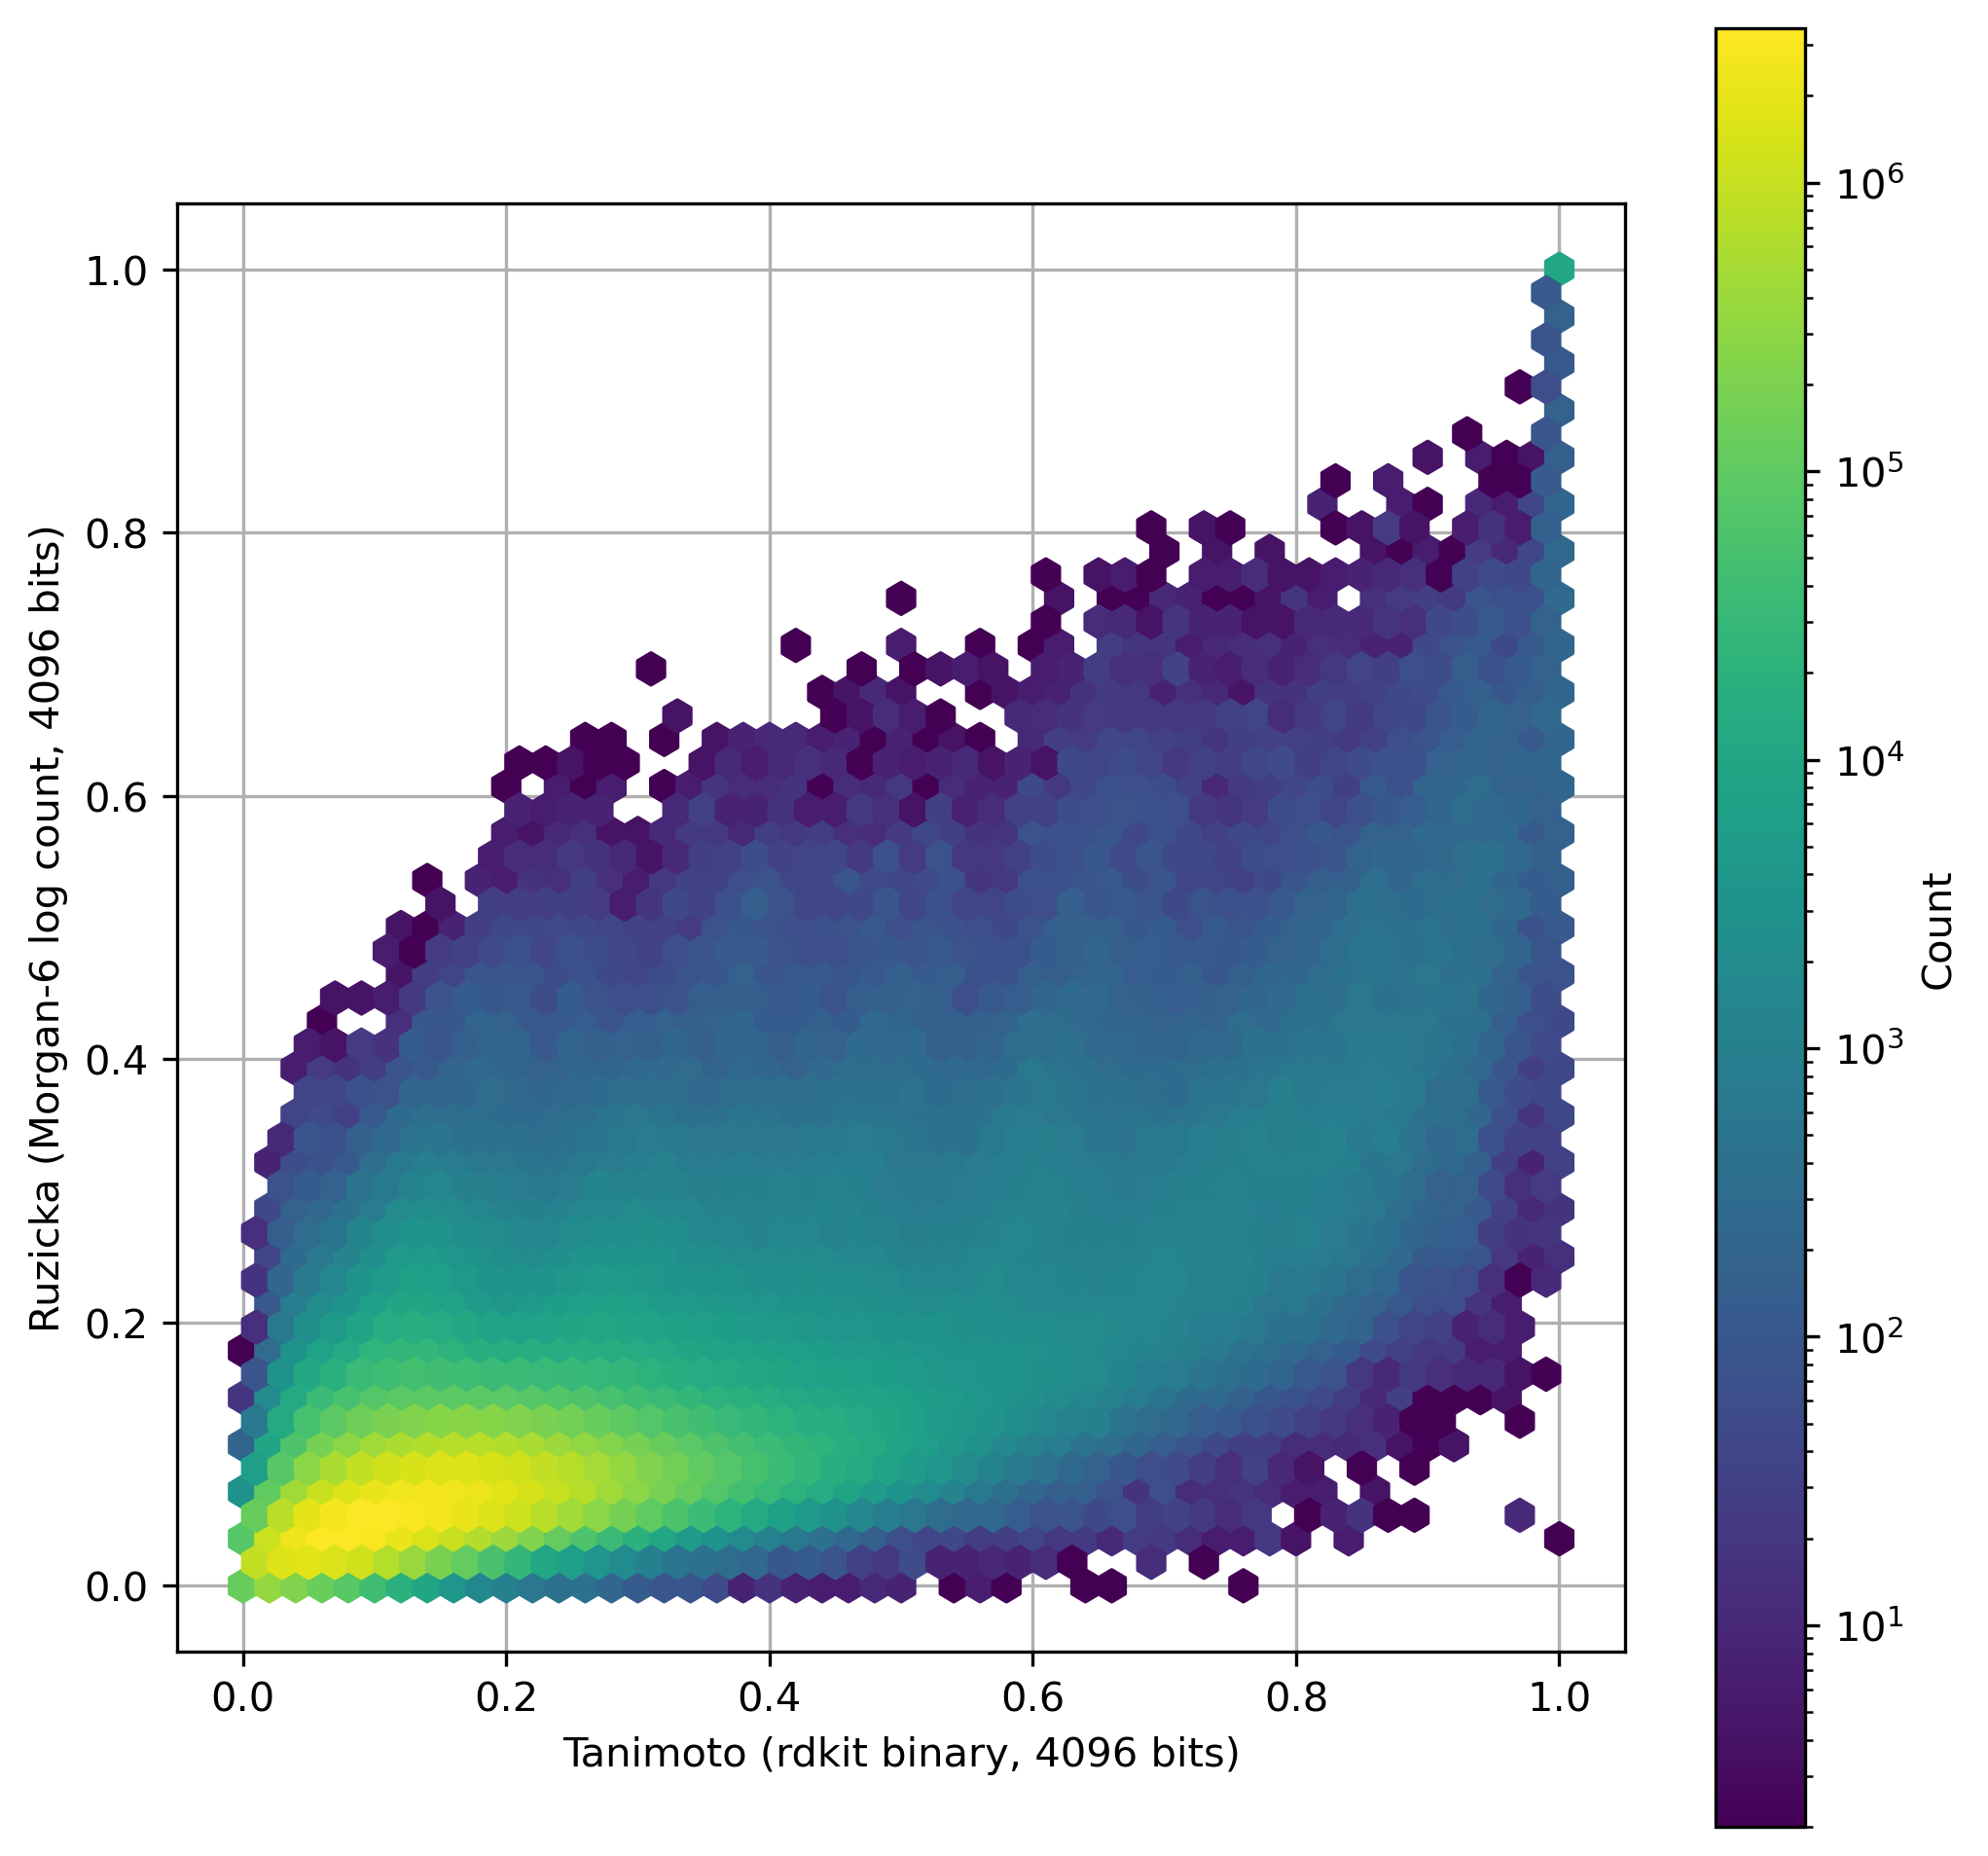

In [102]:
hex_comparison(
    similarities_classic,
    similarities_count_morgan6_log,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-6 log count, {NBITS} bits)",
)

In [104]:
def get_score_summary(id1, id2):
    scores = {
        "Tanimoto (binary fp)": similarities_classic[id1, id2],
        #"Weigthed Tanimoto (binary fp)": similarities_binary_weighted[id1, id2],
        "Ruzicka (Morgan-3 count fp)": similarities_count_morgan3[id1, id2],
        "Ruzicka (Morgan-6 count fp)": similarities_count_morgan6[id1, id2],
        "Ruzicka (Morgan-6 log-count fp)": similarities_count_morgan6_log[id1, id2],
        #"Weighted Ruzicka (count fp)": similarities_count_weighted[id1, id2],
        #"Weighted Ruzicka (log-count fp)": similarities_count_log_weighted[id1, id2],
        #"(Ruzicka (log-tfidf count fp)": similarities_tfidf_log[id1, id2],
    }
    scores = pd.DataFrame.from_dict(scores, orient='index', columns=["Score"])
    return scores

In [105]:
idx = np.where((similarities_count > 0.9) \
               & (similarities_count_morgan6 < 0.7))
idx

(array([  54,  537,  611, 1412, 2614, 2786, 2853, 2917, 3297, 3332, 3708,
        3714, 3714, 4112, 5012, 5493, 5657, 5919, 5919, 6023, 6621, 6785,
        6794, 6821, 6945, 6945, 7090, 7561, 7729, 7929, 8047, 8293, 8456,
        9103, 9620, 9991]),
 array([5493, 6945, 1412,  611, 4112, 8456, 8047, 9991, 3708, 7090, 3297,
        5919, 8293, 2614, 7729,   54, 7561, 3714, 6945, 9103, 6785, 6621,
        7929, 9620,  537, 5919, 3332, 5657, 5012, 6794, 2853, 3714, 2786,
        6023, 6821, 2917]))

In [106]:
pairs = list(zip(idx[0], idx[1]))
unique_pairs = set()
for pair in pairs:
    sorted_pair = tuple(sorted(pair))
    unique_pairs.add(sorted_pair)
unique_pairs = list(unique_pairs)
unique_pairs

[(np.int64(3714), np.int64(8293)),
 (np.int64(2786), np.int64(8456)),
 (np.int64(611), np.int64(1412)),
 (np.int64(5012), np.int64(7729)),
 (np.int64(54), np.int64(5493)),
 (np.int64(3297), np.int64(3708)),
 (np.int64(5657), np.int64(7561)),
 (np.int64(2614), np.int64(4112)),
 (np.int64(3714), np.int64(5919)),
 (np.int64(2853), np.int64(8047)),
 (np.int64(537), np.int64(6945)),
 (np.int64(2917), np.int64(9991)),
 (np.int64(6023), np.int64(9103)),
 (np.int64(5919), np.int64(6945)),
 (np.int64(6621), np.int64(6785)),
 (np.int64(6794), np.int64(7929)),
 (np.int64(6821), np.int64(9620)),
 (np.int64(3332), np.int64(7090))]

,Score
Tanimoto (binary fp),0.975904
Ruzicka (Morgan-3 count fp),0.937008
Ruzicka (Morgan-6 count fp),0.690909
Ruzicka (Morgan-6 log-count fp),0.622285


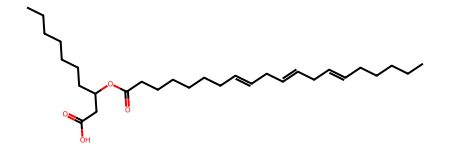

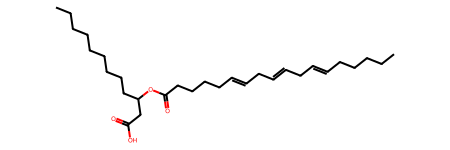

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.917808
Ruzicka (Morgan-6 count fp),0.663934
Ruzicka (Morgan-6 log-count fp),0.621252


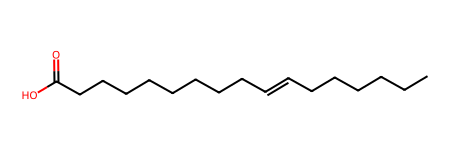

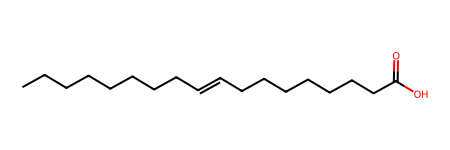

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.920792
Ruzicka (Morgan-6 count fp),0.682635
Ruzicka (Morgan-6 log-count fp),0.637080


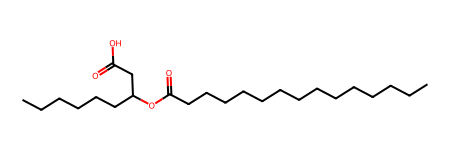

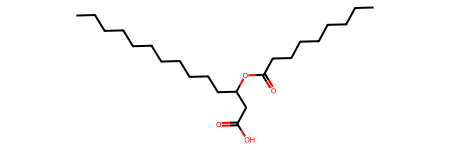

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.905660
Ruzicka (Morgan-6 count fp),0.685714
Ruzicka (Morgan-6 log-count fp),0.627691


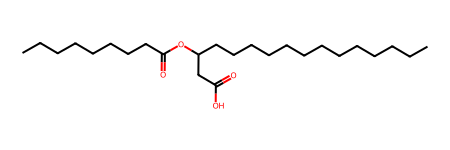

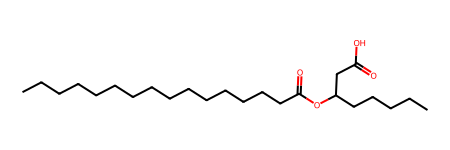

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.901235
Ruzicka (Morgan-6 count fp),0.617647
Ruzicka (Morgan-6 log-count fp),0.571007


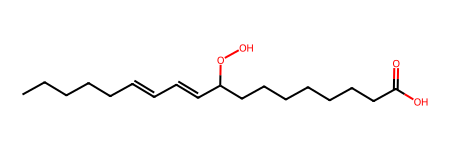

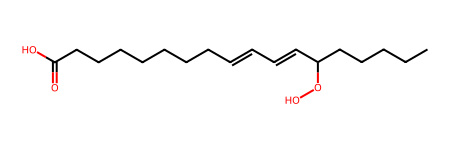

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.905882
Ruzicka (Morgan-6 count fp),0.625000
Ruzicka (Morgan-6 log-count fp),0.580816


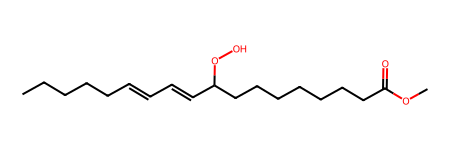

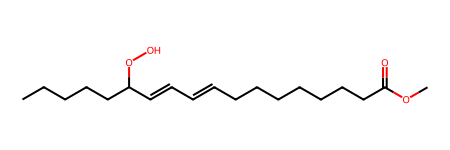

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.915789
Ruzicka (Morgan-6 count fp),0.645570
Ruzicka (Morgan-6 log-count fp),0.576056


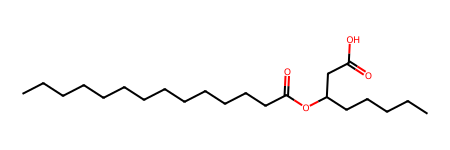

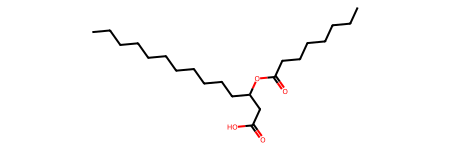

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.906977
Ruzicka (Morgan-6 count fp),0.668966
Ruzicka (Morgan-6 log-count fp),0.628604


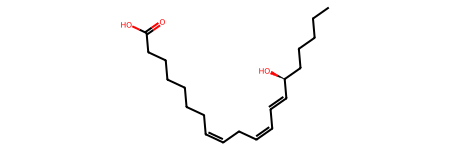

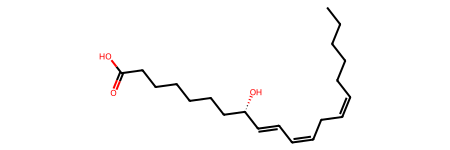

,Score
Tanimoto (binary fp),0.975904
Ruzicka (Morgan-3 count fp),0.920635
Ruzicka (Morgan-6 count fp),0.689815
Ruzicka (Morgan-6 log-count fp),0.632140


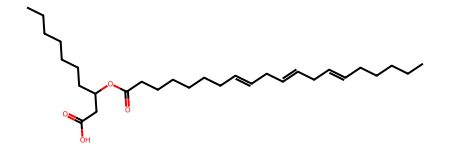

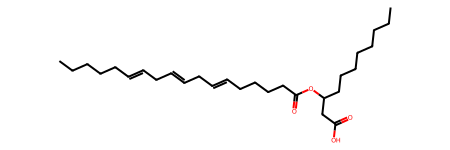

,Score
Tanimoto (binary fp),0.938824
Ruzicka (Morgan-3 count fp),0.917431
Ruzicka (Morgan-6 count fp),0.636816
Ruzicka (Morgan-6 log-count fp),0.550062


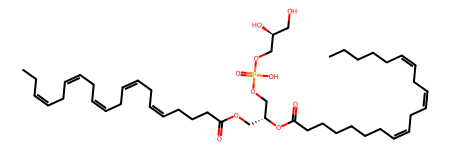

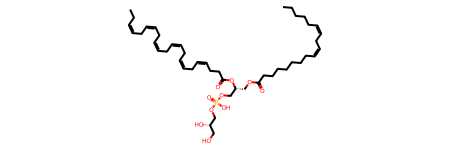

,Score
Tanimoto (binary fp),0.975904
Ruzicka (Morgan-3 count fp),0.902439
Ruzicka (Morgan-6 count fp),0.671429
Ruzicka (Morgan-6 log-count fp),0.611920


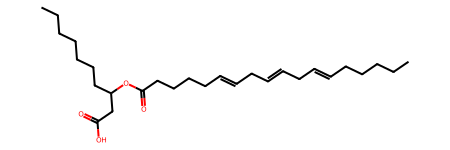

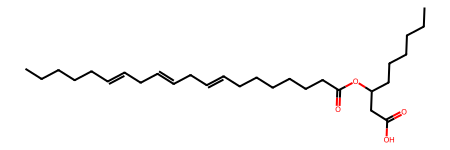

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.909091
Ruzicka (Morgan-6 count fp),0.673333
Ruzicka (Morgan-6 log-count fp),0.614753


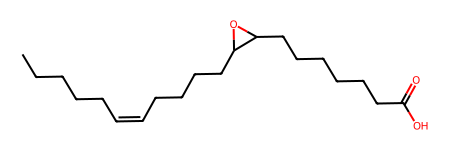

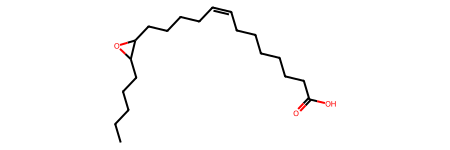

,Score
Tanimoto (binary fp),0.991736
Ruzicka (Morgan-3 count fp),0.937500
Ruzicka (Morgan-6 count fp),0.697436
Ruzicka (Morgan-6 log-count fp),0.652863


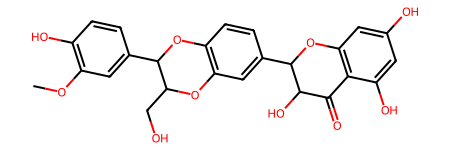

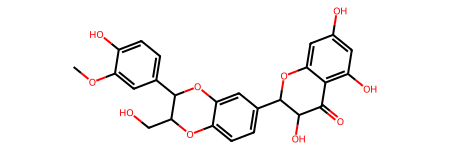

,Score
Tanimoto (binary fp),0.975904
Ruzicka (Morgan-3 count fp),0.919355
Ruzicka (Morgan-6 count fp),0.672897
Ruzicka (Morgan-6 log-count fp),0.601483


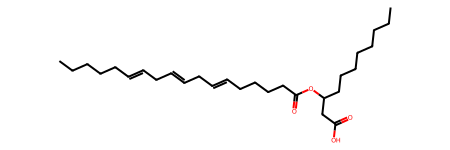

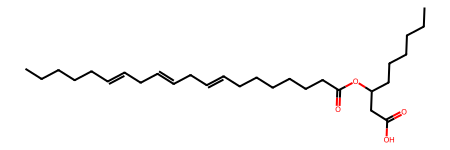

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.913978
Ruzicka (Morgan-6 count fp),0.689655
Ruzicka (Morgan-6 log-count fp),0.645364


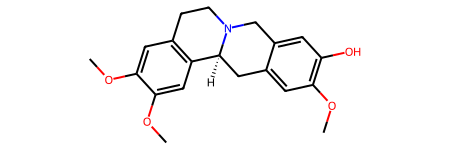

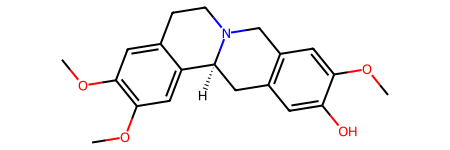

,Score
Tanimoto (binary fp),0.979522
Ruzicka (Morgan-3 count fp),0.946903
Ruzicka (Morgan-6 count fp),0.682382
Ruzicka (Morgan-6 log-count fp),0.616067


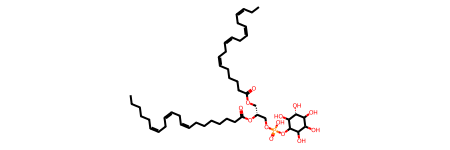

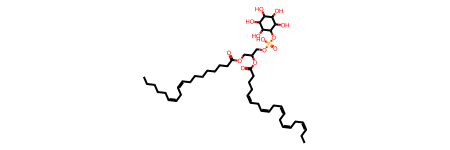

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.942446
Ruzicka (Morgan-6 count fp),0.693780
Ruzicka (Morgan-6 log-count fp),0.633877


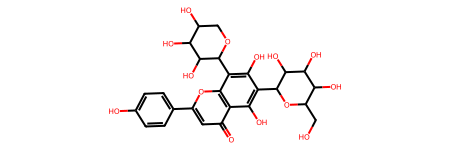

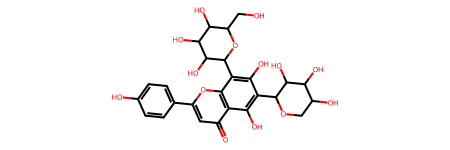

,Score
Tanimoto (binary fp),0.982558
Ruzicka (Morgan-3 count fp),0.917526
Ruzicka (Morgan-6 count fp),0.662651
Ruzicka (Morgan-6 log-count fp),0.615297


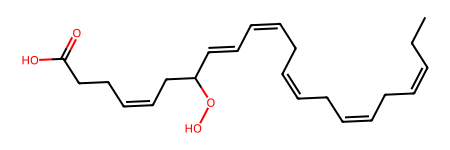

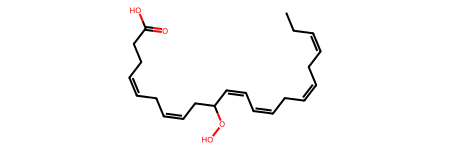

In [107]:
from rdkit import Chem
from rdkit.Chem import Draw


for pair in unique_pairs:
    display(get_score_summary(pair[0], pair[1]))

    smiles1 = compounds.smiles[indices_selected[pair[0]]]
    smiles2 = compounds.smiles[indices_selected[pair[1]]]
    mol = Chem.MolFromSmiles(smiles1)
    display(mol)
    mol = Chem.MolFromSmiles(smiles2)
    display(mol)

In [108]:
idx = np.where((similarities_count_morgan3 > 0.95) \
               & (similarities_count_morgan6_log < 0.7))
idx

(array([5420, 7474, 7561, 8030, 8194, 8682]),
 array([8682, 8030, 8194, 7474, 7561, 5420]))

In [109]:
pairs = list(zip(idx[0], idx[1]))
unique_pairs = set()
for pair in pairs:
    sorted_pair = tuple(sorted(pair))
    unique_pairs.add(sorted_pair)
unique_pairs = list(unique_pairs)
unique_pairs

[(np.int64(7474), np.int64(8030)),
 (np.int64(7561), np.int64(8194)),
 (np.int64(5420), np.int64(8682))]

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.963470
Ruzicka (Morgan-6 count fp),0.793103
Ruzicka (Morgan-6 log-count fp),0.695763


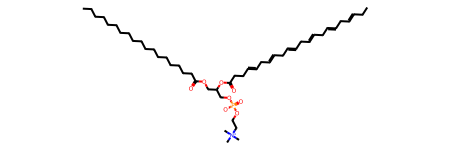

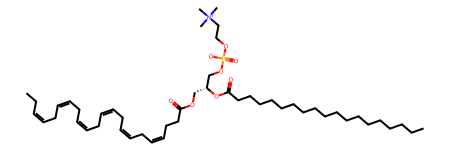

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),1.000000
Ruzicka (Morgan-6 count fp),0.756757
Ruzicka (Morgan-6 log-count fp),0.689111


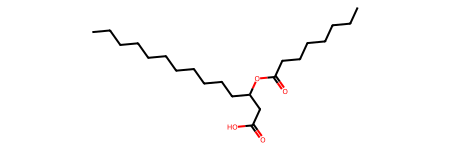

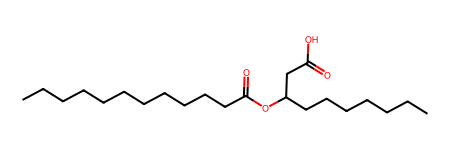

,Score
Tanimoto (binary fp),1.000000
Ruzicka (Morgan-3 count fp),0.970803
Ruzicka (Morgan-6 count fp),0.710744
Ruzicka (Morgan-6 log-count fp),0.620972


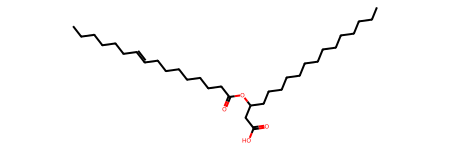

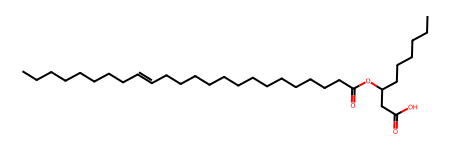

In [110]:
from rdkit import Chem
from rdkit.Chem import Draw


for pair in unique_pairs:
    display(get_score_summary(pair[0], pair[1]))

    smiles1 = compounds.smiles[indices_selected[pair[0]]]
    smiles2 = compounds.smiles[indices_selected[pair[1]]]
    mol = Chem.MolFromSmiles(smiles1)
    display(mol)
    mol = Chem.MolFromSmiles(smiles2)
    display(mol)

In [111]:
idx = np.where((similarities_count_morgan3 > 0.6) \
               & (similarities_count_morgan6_log < 0.25))
idx

(array([1499, 2224, 5012, 5378, 6138, 7186, 7186, 7620, 7620, 7951, 7985,
        9429]),
 array([9429, 7951, 7186, 7620, 7620, 5012, 7985, 5378, 6138, 2224, 7186,
        1499]))

In [112]:
pairs = list(zip(idx[0], idx[1]))
unique_pairs = set()
for pair in pairs:
    sorted_pair = tuple(sorted(pair))
    unique_pairs.add(sorted_pair)
unique_pairs = list(unique_pairs)
unique_pairs

[(np.int64(7186), np.int64(7985)),
 (np.int64(5012), np.int64(7186)),
 (np.int64(2224), np.int64(7951)),
 (np.int64(1499), np.int64(9429)),
 (np.int64(5378), np.int64(7620)),
 (np.int64(6138), np.int64(7620))]

,Score
Tanimoto (binary fp),0.488038
Ruzicka (Morgan-3 count fp),0.608000
Ruzicka (Morgan-6 count fp),0.369863
Ruzicka (Morgan-6 log-count fp),0.245362


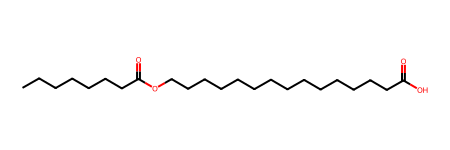

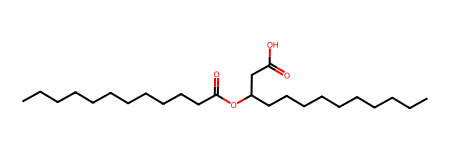

,Score
Tanimoto (binary fp),0.488038
Ruzicka (Morgan-3 count fp),0.608000
Ruzicka (Morgan-6 count fp),0.376147
Ruzicka (Morgan-6 log-count fp),0.245052


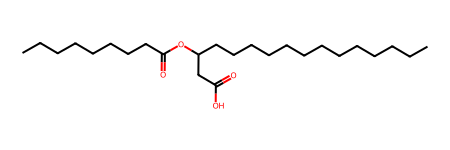

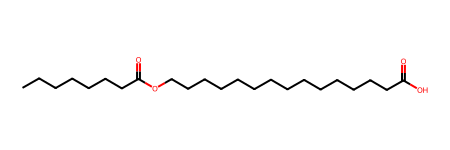

,Score
Tanimoto (binary fp),0.214751
Ruzicka (Morgan-3 count fp),0.601852
Ruzicka (Morgan-6 count fp),0.388325
Ruzicka (Morgan-6 log-count fp),0.247969


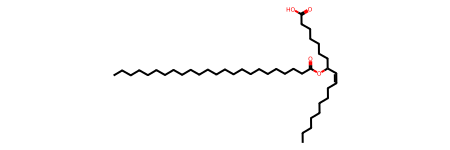

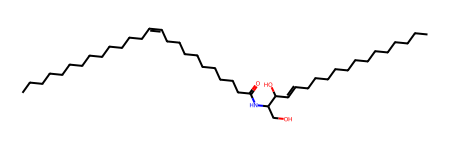

,Score
Tanimoto (binary fp),0.134078
Ruzicka (Morgan-3 count fp),0.622549
Ruzicka (Morgan-6 count fp),0.511429
Ruzicka (Morgan-6 log-count fp),0.241245


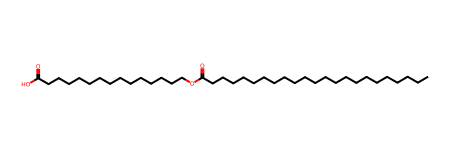

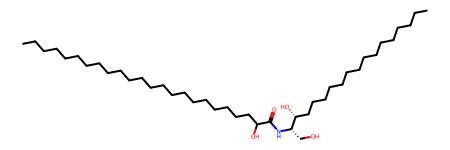

,Score
Tanimoto (binary fp),0.439655
Ruzicka (Morgan-3 count fp),0.605405
Ruzicka (Morgan-6 count fp),0.405405
Ruzicka (Morgan-6 log-count fp),0.245951


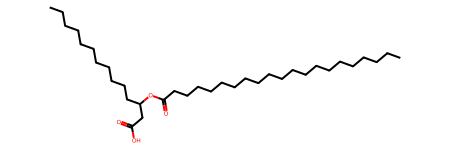

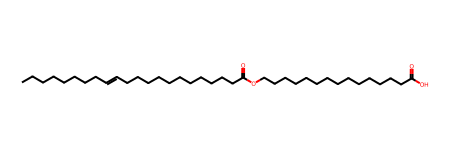

,Score
Tanimoto (binary fp),0.409449
Ruzicka (Morgan-3 count fp),0.601064
Ruzicka (Morgan-6 count fp),0.401760
Ruzicka (Morgan-6 log-count fp),0.247579


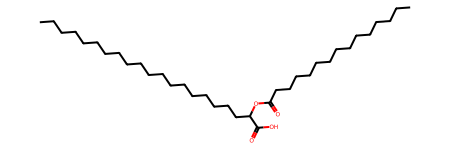

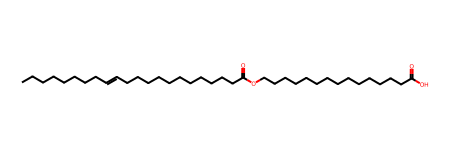

In [113]:
for pair in unique_pairs:
    display(get_score_summary(pair[0], pair[1]))

    smiles1 = compounds.smiles[indices_selected[pair[0]]]
    smiles2 = compounds.smiles[indices_selected[pair[1]]]
    mol = Chem.MolFromSmiles(smiles1)
    display(mol)
    mol = Chem.MolFromSmiles(smiles2)
    display(mol)